In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import glob
import sys
sys.path.extend(['E:/brain/nits'])
from masking import extractMean,testImport,extractTIV,extractCT
from stats import regression
from view import mappingParcellToVolume,volumeToSurface,GMV_Mapping,GMV_MappingAtlas
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

E:\miniconda\envs\brain\lib\site-packages\nilearn\datasets\__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [20]:
ADNI_NC.to_csv('table/NC_ABETA.csv')

In [30]:
ADNI_AD = pd.read_csv('E:/brain/subtype/src/table/AD_ABETA.csv')
ADNI_MCI = pd.read_csv('E:/brain/subtype/src/table/MCI_ABETA.csv')
ADNI_NC = pd.read_csv('E:/brain/subtype/src/table/NC_ABETA.csv')
ADNI_NC['PTGENDER2'] = ADNI_NC['PTGENDER'].apply(lambda x : 1 if x== 'Male' else 2)
ADNI_NC['Years_bl2'] = ADNI_NC['Years_bl'].apply(lambda x : 0 if(pd.isna(x)) else x)
ADNI_NC['AGE2'] = ADNI_NC['AGE'] + ADNI_NC['Years_bl2']
ADNI_Info = pd.concat([ADNI_AD,ADNI_MCI,ADNI_NC])

MCAD_AD = pd.read_excel('E:/brain/subtype/src/mcad_info_687_del670.xlsx')
MCAD_TIVs = pd.read_excel('E:/brain/subtype/src/mcad_info_687_del670.xlsx',sheet_name='tiv')
MCAD_CTs = pd.read_excel('E:/brain/subtype/src/mcad_info_687_del670.xlsx',sheet_name='surf')
GMV_Info = pd.read_csv('D:/DATA/all_info.csv')
ADNI_GMV_Path = 'D:/DATA/ADNI/ROI_GMV/'
BN_atlas = 'E:/brain/BNatlas/BN_Atlas_274_combined_1mm.nii'

In [76]:
ADNI_Info.groupby('DX').mean()

,Unnamed: 0,PTID,DATE,COLPROT_x,PATH,VISCODE2,TR,SLICEORDER,NSLICE,MANUFACTURER,...,GMV,WMV,NewVis_AV45,NewVis_ABETA,Positive,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1
DX,,,,,,,,,,,,,,,,,,,,,
CN,116,116,114,112,114,114,112,114,114,112,...,0,0,116,116,116,116,116,116,116,116
Dementia,82,82,51,51,51,51,51,51,51,51,...,82,82,82,82,82,0,0,0,0,0
MCI,0,93,89,89,89,89,89,89,89,89,...,0,0,93,93,93,0,0,0,0,0


In [109]:
ADNI_MCI = pd.read_csv('E:/brain/subtype/src/table/MCI_ABETA_cluster.csv')

In [128]:
ADNI_Info.loc[:,['PTID','AGE2','PTGENDER','MMSE','cluster','DX']].groupby(['DX']).std()

,AGE2,MMSE,cluster
DX,,,
CN,7.008320,1.099684,NaN
Dementia,8.782646,3.770218,1.074253
MCI,7.698622,1.853506,NaN


In [126]:

from scipy.stats import chisquare
chisquare([[49,48,42],
          67,45,40])

E:\miniconda\envs\brain\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: can only concatenate list (not "int") to list

In [115]:
import statsmodels.formula.api as smi

In [129]:
smi.ols('MMSE ~ DX',data=ADNI_Info).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MMSE   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     204.5
Date:                Fri, 16 Jul 2021   Prob (F-statistic):           6.07e-56
Time:                        10:28:19   Log-Likelihood:                -659.61
No. Observations:                 290   AIC:                             1325.
Df Residuals:                     287   BIC:                             1336.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         29.0348      0.221    131.653      0.000      28.601      29.469
DX[T.Dementia]    -6.7299      0.342    -19.688      0.000      -7.403      -6.057
DX[T.MCI]         -1.4219      0.330     -4.311      0.000      -2.071      -0.773
==============================================================================
Omnibus:                       77.034   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.117
Skew:                          -1.016   Prob(JB):                     2.56e-76
Kurtosis:                       7.968   Cond. No.                         3.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
for index,row in ADNI_Info.iterrows():
    if(pd.isna(row['COLPROT_x'])):
        if(row['VISCODE3']=='bl'):
            ADNI_Info.loc[index,'COLPROT_x'] = row['ORIGPROT']
        else:
            ADNI_Info.loc[index,'COLPROT_x'] = 'ADNI3'
            

In [14]:
ADNI_GMV_Data = np.zeros([ADNI_Info.shape[0],274])
TIVs = np.zeros([ADNI_Info.shape[0]])
i=0
for index,row in ADNI_Info.iterrows():
    path = glob.glob('D:/DATA/ADNI/ADNI_T1/mri/smwp1*'+row['PTID']+'*.nii')
    if(len(path)!=0):
        ADNI_GMV_Data[i,:] = extractMean([path[0]],BN_atlas)
        reportPath = glob.glob('D:/DATA/ADNI/ADNI_T1/report/cat*'+row['PTID']+'*.mat')[0]
        TIVs[i],*_ = extractTIV(reportPath)
    else:
        path = ADNI_GMV_Path+row['COLPROT_x']+'/'+row['PTID']+'.csv'
        if not os.path.exists(path):
            path = glob.glob(ADNI_GMV_Path+'*'+'/'+row['PTID']+'.csv')
            if(len(path)==0):
                print(row['PTID'],row['VISCODE3'],row['DATE'])
                continue
            else:
                path = path[0]
        ADNI_GMV_Data[i,:] = pd.read_csv(path)['mean'].values
        TIVs[i]=GMV_Info.loc[GMV_Info['subject_name']==row['PTID'],'TIV'].values[0]
    i+=1

In [15]:
ADNI_CT_Path = 'D:/DATA/ADNI/ROI_CT/ADNI/'
ADNI_CT_Data = np.zeros([ADNI_Info.shape[0],210])
i=0
for index,row in ADNI_Info.iterrows():
    path = glob.glob('D:/DATA/ADNI/ADNI_T1/mri/smwp1*'+row['PTID']+'*.nii')
    if(len(path)!=0):
        reportPath = glob.glob('D:/DATA/ADNI/ADNI_T1/label/cat*'+row['PTID']+'*.mat')[0]
        ADNI_CT_Data[i,:] = extractCT(reportPath)
    else:
        path = ADNI_CT_Path+row['COLPROT_x']+'/'+row['PTID']+'.csv'
        if not os.path.exists(path):
            path = glob.glob(ADNI_CT_Path+'*'+'/'+row['PTID']+'.csv')
            if(len(path)==0):
                print(ADNI_CT_Path+'*'+'/'+row['PTID']+'.csv')
                print(row['PTID'],row['VISCODE3'],row['DATE'],row['COLPROT_x'])
                continue
            else:
                path = path[0]
        ADNI_CT_Data[i,:] = pd.read_csv(path)['CT'].values
    i+=1

In [33]:
def changeName(x):
    if(x=='CN'):
        return 1
    elif(x=='MCI'):
        return 2
    elif(x=='Dementia'):
        return 3

In [34]:
infoTable = pd.DataFrame(columns=['AGE','GENDER','batch','GROUP'])
infoTable[['AGE','GENDER','batch','GROUP']] = ADNI_Info.loc[:,['AGE2','PTGENDER2','SITE','DX']]
infoTable['GROUP']=infoTable['GROUP'].apply(changeName)
infoTable['batch'] = infoTable['batch'].astype('object')
infoTable['batch'] = infoTable['batch'].apply(lambda x:'ADNI'+str(x))
infoTable['TIV'] = TIVs

In [26]:
MCAD_GMV_Paths = ["D:\DATA\MCAD\ROI_GMV\AD_S03","D:\DATA\MCAD\ROI_GMV\AD_S02","D:\DATA\MCAD\ROI_GMV\AD_S01",
                  "D:\DATA\MCAD\ROI_GMV\AD_S04","D:\DATA\MCAD\ROI_GMV\AD_S05","D:\DATA\MCAD\ROI_GMV\AD_S06",
                  "D:\DATA\MCAD\ROI_GMV\AD_S07"]

In [27]:
MCAD_GMV_Data = np.zeros([MCAD_AD.shape[0],274])
i=0
groupName = {1:'NC',2:'MC',3:'AD'}
absentData = pd.DataFrame()
for index,row in MCAD_AD.iterrows():
    MCAD_GMV_Path = MCAD_GMV_Paths[int(row['center'])-1]
    path =  r"D:\DATA\MCAD\ROI_GMV/"+'smwp1'+row['Subj_fmri']+'.nii'
    if(row['center']==4):
        if(os.path.exists(path)):
            MCAD_GMV_Data[i,:] = extractMean([path],BN_atlas)
            i+=1
            continue
    csv_path = MCAD_GMV_Path+'/'+row['Subj_fmri']+'.csv'
    if(row['center']==1):
        csv_path = MCAD_GMV_Path+'/'+str(row['Group'])+'_'+groupName[row['Group']]+row['Subj_fmri'][-3:]+'.csv'
    if(row['center']==5):
        csv_path = MCAD_GMV_Path+'/'+row['Subj_fmri'][2:]+'.csv'
    if(row['center']==6):
        csv_path = MCAD_GMV_Path+'/'+str(row['Group'])+'_'+groupName[row['Group']]+row['Subj_fmri'][-3:]+'.csv'
    if(not os.path.exists(csv_path)):
        path =  r"D:\DATA\MCAD\ROI_GMV/"+'smwp1'+row['Subj_fmri']+'.nii'
        MCAD_GMV_Data[i,:] = extractMean([path],BN_atlas)
        #print(row['Subj_fmri'])
        i+=1
        continue
    MCAD_GMV_Data[i,:] = pd.read_csv(csv_path)['mean'].values
    i+=1

<AxesSubplot:>

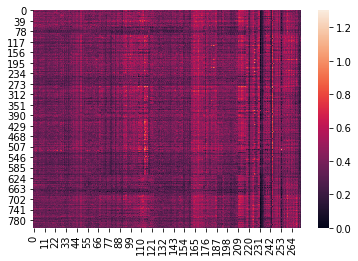

In [20]:
sns.heatmap(MCAD_GMV_Data)

In [22]:
All_CT.shape

NameError: name 'All_CT' is not defined

In [31]:
MCAD_Combat_Info = pd.DataFrame(columns=infoTable.columns)
MCAD_Combat_Info['AGE'] = MCAD_AD['Age']
MCAD_Combat_Info['GENDER'] = MCAD_AD['Gender']
MCAD_Combat_Info['batch'] = MCAD_AD['center'].apply(lambda x: 'MCAD'+str(x))
MCAD_Combat_Info['GROUP'] = MCAD_AD['Group']
MCAD_Combat_Info['TIV'] = MCAD_TIVs['tiv']

In [35]:
All_Combat_Info = pd.concat([infoTable,MCAD_Combat_Info])
All_GMV = np.vstack([ADNI_GMV_Data,MCAD_GMV_Data])

In [181]:
All_CT = np.vstack([ADNI_CT_Data,MCAD_CTs])
pd.DataFrame(All_CT.T,index=None).to_csv('ADATA/All_CT.csv',index=None)

In [136]:
pd.DataFrame(All_GMV,index=None).to_csv('ADATA/All_GMV.csv',index=None)

In [135]:
All_Combat_Info.to_csv('ADATA/All_Info.csv')

In [30]:
All_Combat_Info = pd.read_csv('ADATA/All_Info.csv')

In [8]:
CombatData = np.loadtxt('E:/brain/subtype/src/ADATA/GMV_Combat.txt')

In [9]:
CombatCT = np.loadtxt('E:/brain/subtype/src/ADATA/CT_Combat.txt').T

In [187]:
CombatData.shape

(274, 1100)

In [36]:
H_PATH = "data/MCAD_H_Combat.txt"
H = np.loadtxt(H_PATH)
MCAD_Cluster = np.argmin(H, axis=0)
ADNI_Cluster = pd.read_csv('E:/brain/subtype/src/table/AD_ABETA_cluster.csv')['cluster'].values
AD_Cluster = np.hstack([ADNI_Cluster,MCAD_Cluster])

In [37]:
AD_NC_Info

NameError: name 'AD_NC_Info' is not defined

In [94]:
Reg_Combat_Data = np.zeros_like(CombatData.T[All_Combat_Info['GROUP']!=2])

In [95]:
Reg_Combat_CT = np.zeros_like(CombatCT[All_Combat_Info['GROUP']!=2])
AD_NC_Info = All_Combat_Info[All_Combat_Info['GROUP']!=2]
AD_NC_GMV = CombatData.T[All_Combat_Info['GROUP']!=2]
AD_NC_CT = CombatCT[All_Combat_Info['GROUP']!=2]

In [96]:
Reg_Combat_Data = np.zeros_like(CombatData.T)
Reg_Combat_CT = np.zeros_like(CombatCT)
AD_NC_Info = All_Combat_Info
AD_NC_GMV = CombatData.T
AD_NC_CT = CombatCT

In [97]:
for i in range(274):
    AD_NC_Info.loc[:,'GMV'] = AD_NC_GMV[:,i]
    res = smf.ols('GMV~AGE+GENDER+TIV',data=AD_NC_Info).fit()
    Reg_Combat_Data[:,i] = res.resid
for i in range(210):
    AD_NC_Info.loc[:,'CT'] = AD_NC_CT[:,i]
    res = smf.ols('CT~AGE+GENDER+TIV',data=AD_NC_Info).fit()
    Reg_Combat_CT[:,i] = res.resid

In [98]:
AD_GMV = Reg_Combat_Data[AD_NC_Info['GROUP']==3]
NC_GMV = Reg_Combat_Data[AD_NC_Info['GROUP']==1]
AD_CT = Reg_Combat_CT[AD_NC_Info['GROUP']==3]
NC_CT = Reg_Combat_CT[AD_NC_Info['GROUP']==1]


In [43]:
pcmap2 = sns.color_palette('flare', as_cmap=True)
pcmap = sns.color_palette('Oranges', as_cmap=True)
ncmap = sns.color_palette('Blues_r', as_cmap=True)

Subtype & NC

In [60]:
for i in range(4):
    ts = []
    ps = []
    for j in range(274):
        t,p,df =  ttest_ind(AD_GMV[AD_Cluster==i,j],NC_GMV[:,j])
        ts.append(t)
        ps.append(p)
    _,fdr = fdrcorrection(ps)
    
    ts = np.array(ts)
    ps = np.array(ps)
    #ts[fdr>0.05]=0
    ts[ps*274>0.05]=0
    res = mappingParcellToVolume(ts,BN_atlas)
    #res.to_filename('DrawGMV/Subtype%d_VS_NC_FWE_0.053.nii' % i)
    GMV_MappingAtlas([res],pos_max=13, pos_min=3, neg_max=-3.8, neg_min=-22, pcmap=ncmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_274_combined_1mm.nii',savePath='DrawGMV',saveName='Subtype%d_VS_NC_FWE' % i,MAX=True)

Negative:
min: -19.836258928693972 max: -3.795746369697711
Negative:
min: -23.658295090178935 max: -3.894332901244023
Negative:
min: -19.515582063509534 max: -3.7761115751656265
Negative:
min: -18.25056894805187 max: -3.7889248409957057


GMV subtype paired

In [218]:
for i in range(3):
    for k in range(i+1,4):
        ts = []
        ps = []
        for j in range(274):
            t,p,df =  ttest_ind(AD_GMV[AD_Cluster==i,j],AD_GMV[AD_Cluster==k,j])
            ts.append(t)
            ps.append(p)
        _,fdr = fdrcorrection(ps)
        ts = np.array(ts)
        ps = np.array(ps)
        ts[ps>0.05]=0
        res = mappingParcellToVolume(ts,BN_atlas)
        res.to_filename('DrawGMV/Subtype%d_VS_Subtype%d.nii' % (i+1,k+1))
        GMV_MappingAtlas([res],pos_max=5, pos_min=0.01, neg_max=0.01, neg_min=-4, pcmap=pcmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_274_combined_1mm.nii',savePath='DrawGMV',saveName='Subtype%d_VS_Subtype%d' % (i+1,k+1),MAX=True)

Postive:
min: 1.9754686523879814 max: 5.23936409210144
Postive:
min: 1.9765375745502447 max: 5.357609099131073
Postive:
min: 1.9814738125192906 max: 4.667594781449504
Negative:
min: -2.7762528535956403 max: -2.7762528535956403
Postive:
min: 2.105448215864858 max: 3.2398733446339434
Negative:
min: -3.0612232822054146 max: -2.025512119655949
Postive:
min: 2.193375711998861 max: 2.193375711998861
Negative:
min: -3.073473535838417 max: -1.9802668508887509
Postive:
min: 2.0071511396477013 max: 3.1857595010799935
Negative:
min: -2.6690405811023457 max: -2.0364847120425345


## GMV Subtype & Others

In [85]:
for k in range(4):
        ts = []
        ps = []
        for j in range(263):
            t,p,df =  ttest_ind(AD_GMV[AD_Cluster==k,j],AD_GMV[AD_Cluster!=k,j])
            ts.append(t)
            ps.append(p)
        _,fdr = fdrcorrection(ps)
        ts = np.array(ts)
        ts[fdr>0.05]=0
        res = mappingParcellToVolume(ts,BN_atlas)
        res.to_filename('DrawGMV/Subtype%d_VS_Other_fdr.nii' % (k+1))
        GMV_MappingAtlas([res],pos_max=5, pos_min=0.01, neg_max=0.01, neg_min=-4, pcmap=pcmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_274_combined_1mm.nii',savePath='DrawGMV',saveName='Subtype%d_VS_Other_fdr' % (k+1),MAX=True)

IndexError: index 263 is out of bounds for axis 0 with size 263

## GMV ANOVA 

In [209]:
ts = []
ps = []
for j in range(274):
    f,p =  f_oneway(AD_GMV[AD_Cluster==0,j],AD_GMV[AD_Cluster==1,j],AD_GMV[AD_Cluster==2,j],AD_GMV[AD_Cluster==3,j])
    ts.append(t)
    ps.append(p)
_,fdr = fdrcorrection(ps)
ts = np.array(ts)
ts[fdr>0.05]=0
res = mappingParcellToVolume(ts,BN_atlas)
res.to_filename('DrawGMV/SubtypeANOVA_GMV.nii')

## CT

In [219]:
for i in range(3):
    for k in range(i+1,4):
        ts = []
        ps = []
        for j in range(210):
            t,p,df =  ttest_ind(AD_CT[AD_Cluster==i,j],AD_CT[AD_Cluster==k,j])
            ts.append(t)
            ps.append(p)
        _,fdr = fdrcorrection(ps)
        ts = np.array(ts)
        ps = np.array(ps)
        ts[ps>0.05]=0
        res = mappingParcellToVolume(ts,'E:/brain/BNatlas/BN_Atlas_210_1mm.nii')
        res.to_filename('DrawGMV/CT_Subtype%d_VS_Subtype%d.nii' % (i+1,k+1))
        GMV_MappingAtlas([res],pos_max=5, pos_min=0.01, neg_max=0.01, neg_min=-4, pcmap=pcmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_210_1mm.nii',savePath='DrawGMV',saveName='CT_Subtype%d_VS_Subtype%d' % (i+1,k+1),MAX=True)

Postive:
min: 1.976962048283519 max: 4.544855693742333
Postive:
min: 1.972069122468523 max: 4.5608686250189185
Negative:
min: -2.627809475577879 max: -2.093653205082371
Postive:
min: 1.9916370984226046 max: 4.323194828264858
Postive:
min: 2.1448128514715528 max: 2.9237738341354635
Negative:
min: -4.468906159896056 max: -2.001011189049513
Postive:
min: 2.103973330671468 max: 2.642337178526412
Negative:
min: -2.333982383249559 max: -2.05063433019143
Postive:
min: 2.003767311311651 max: 2.949975476270186
Negative:
min: -2.823929559412122 max: -2.008143716494277


In [93]:
for i in range(4):
    ts = []
    ps = []
    for j in range(210):
        t,p,df =  ttest_ind(AD_CT[AD_Cluster==i,j],AD_CT[AD_Cluster!=i,j])
        ts.append(t)
        ps.append(p)
    _,fdr = fdrcorrection(ps)
    ts = np.array(ts)
    ps = np.array(ps)
    ts[ps>0.05]=0
    res = mappingParcellToVolume(ts,'E:/brain/BNatlas/BN_Atlas_210_1mm.nii')
    res.to_filename('DrawGMV/CT_Subtype%d_VS_Other.nii' % (i+1))
    GMV_MappingAtlas([res],pos_max=5, pos_min=0.01, neg_max=0.01, neg_min=-3.9, pcmap=pcmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_210_1mm.nii',savePath='DrawGMV',saveName='CT_Subtype%d_VS_Other' % (i+1),MAX=True)

Postive:
min: 1.9719173373640402 max: 5.032960049017115
Negative:
min: -3.9129405097322003 max: -1.9773483307603845
Postive:
min: 2.038493480979821 max: 4.00645902135886
Negative:
min: -3.3906825588610476 max: -1.981960683373094
Negative:
min: -3.2986078502394243 max: -2.001879361938175


In [100]:
names = ['Frontal','Temporal','Parietal','Cingulate','Occipital']
Regional_volume = np.zeros([AD_GMV.shape[0],5])
Regional_volume[:,0] = np.mean(AD_GMV[:,:68],axis=1)
Regional_volume[:,1] = np.mean(AD_GMV[:,68:124],axis=1)
Regional_volume[:,2] = np.mean(AD_GMV[:,124:162],axis=1)
Regional_volume[:,3] = np.mean(AD_GMV[:,174:188],axis=1)
Regional_volume[:,4] = np.mean(AD_GMV[:,188:210],axis=1)
NC_Regional_volume = np.zeros([NC_GMV.shape[0],5])
NC_Regional_volume[:,0] = np.mean(NC_GMV[:,:68],axis=1)
NC_Regional_volume[:,1] = np.mean(NC_GMV[:,68:124],axis=1)
NC_Regional_volume[:,2] = np.mean(NC_GMV[:,124:162],axis=1)
NC_Regional_volume[:,3] = np.mean(NC_GMV[:,174:188],axis=1)
NC_Regional_volume[:,4] = np.mean(NC_GMV[:,188:210],axis=1)
AtrophyData = np.hstack([AD_Cluster.reshape([-1,1]),Regional_volume])
AtrophyDf = pd.DataFrame(AtrophyData,columns=['Subtype','Frontal','Temporal','Parietal','Cingulate','Occipital'])
z_scaler = lambda x : (x - np.mean(x)) / np.std(x)
AtrophyDf.iloc[:,1:] = AtrophyDf.iloc[:,1:].apply(z_scaler)
from stats import oneway_Anova
columns = ['Frontal','Temporal','Parietal','Cingulate','Occipital']
resData = pd.DataFrame(
        columns=['Item', 'F', 'P', 'ST1-2T', 'ST1-2P', 'ST1-3T', 'ST1-3P', 'ST1-4T', 'ST1-4P', 'ST2-3T', 'ST2-3P',
                 'ST2-4T', 'ST2-4P', 'ST3-4T', 'ST3-4P'])
AtrophyDf['Subtype'] = AtrophyDf['Subtype'].astype('int64')+1
AtrophyDf['Subtype'] = AtrophyDf['Subtype'].astype('object')
for c in columns:
    resultsDict = {}
    res = oneway_Anova(AtrophyDf,c,'Subtype')
    resultsDict['Item'] = c
    resultsDict['F'] = res.loc['Subtype','F']
    resultsDict['P'] = res.loc['Subtype','PR(>F)']

    print('====================================================')
    print(res)
    for c1 in [1,2,3]:
        for c2 in range(c1+1,5):
            t,p = scipy.stats.ttest_ind(AtrophyDf.loc[AtrophyDf['Subtype']== c1,c],
                                        AtrophyDf.loc[AtrophyDf['Subtype']== c2,c])

            resultsDict['ST%d-%dT' % (c1,c2)] = t
            resultsDict['ST%d-%dP' % (c1,c2)] = p
    
    resData = resData.append(pd.DataFrame(resultsDict,index=[0]))
    print(resData)
    print('====================================================')
resData.to_csv('table/RegionalCT_ANOVA.csv')

Frontal~Subtype
             df      sum_sq   mean_sq         F    PR(>F)
Subtype     3.0   18.111355  6.037118  6.274495  0.000366
Residual  373.0  358.888645  0.962168       NaN       NaN
      Item         F         P    ST1-2T    ST1-2P    ST1-3T    ST1-3P  \
0  Frontal  6.274495  0.000366  3.893297  0.000129  3.355901  0.000947   

     ST1-4T    ST1-4P    ST2-3T    ST2-3P    ST2-4T    ST2-4P    ST3-4T  \
0  2.423349  0.016421 -0.075208  0.940124 -0.522103  0.602263 -0.411401   

     ST3-4P  
0  0.681417  
Temporal~Subtype
             df      sum_sq   mean_sq          F    PR(>F)
Subtype     3.0   28.460707  9.486902  10.152699  0.000002
Residual  373.0  348.539293  0.934422        NaN       NaN
       Item          F         P    ST1-2T    ST1-2P    ST1-3T    ST1-3P  \
0   Frontal   6.274495  0.000366  3.893297  0.000129  3.355901  0.000947   
0  Temporal  10.152699  0.000002  5.021869  0.000001  3.821435  0.000177   

     ST1-4T    ST1-4P    ST2-3T    ST2-3P    ST2-4T    ST2-

In [ ]:
names = ['Frontal','Temporal','Parietal','Cingulate','Occipital','Hippocampus','Basal Ganglia']
Regional_volume = np.zeros([AD_GMV.shape[0],7])
Regional_volume[:,0] = np.mean(AD_GMV[:,:68],axis=1)
Regional_volume[:,1] = np.mean(AD_GMV[:,68:124],axis=1)
Regional_volume[:,2] = np.mean(AD_GMV[:,124:162],axis=1)
Regional_volume[:,3] = np.mean(AD_GMV[:,174:188],axis=1)
Regional_volume[:,4] = np.mean(AD_GMV[:,188:210],axis=1)
Regional_volume[:,5] = np.mean(AD_GMV[:,214:218],axis=1)
Regional_volume[:,6] = np.mean(AD_GMV[:,218:230],axis=1)

In [88]:
NC_Regional_volume = np.zeros([NC_GMV.shape[0],7])
NC_Regional_volume[:,0] = np.mean(NC_GMV[:,:68],axis=1)
NC_Regional_volume[:,1] = np.mean(NC_GMV[:,68:124],axis=1)
NC_Regional_volume[:,2] = np.mean(NC_GMV[:,124:162],axis=1)
NC_Regional_volume[:,3] = np.mean(NC_GMV[:,174:188],axis=1)
NC_Regional_volume[:,4] = np.mean(NC_GMV[:,188:210],axis=1)
NC_Regional_volume[:,5] = np.mean(NC_GMV[:,214:218],axis=1)
NC_Regional_volume[:,6] = np.mean(NC_GMV[:,218:230],axis=1)

<AxesSubplot:>

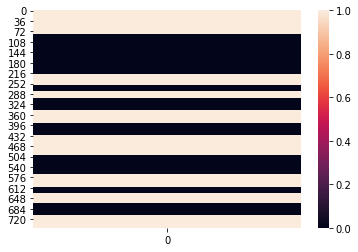

In [46]:
sns.heatmap((AD_NC_Info['GROUP']==3).values.reshape([-1,1]))

In [47]:
AD_NC_Info[AD_NC_Info['GROUP']==3]

,AGE,GENDER,batch,GROUP,TIV,GMV,CT
0,70.099320,2,ADNI2,3,1277.615843,0.172061,1.995454
1,77.826690,2,ADNI2,3,1383.853847,0.161182,2.194503
2,72.965090,1,ADNI2,3,1562.849427,0.270077,2.337563
3,73.798289,1,ADNI2,3,1508.918191,0.337125,2.469376
4,55.300000,1,ADNI3,3,1503.349592,0.309684,2.178052
...,...,...,...,...,...,...,...
804,53.000000,1,MCAD7,3,1424.380278,0.294818,1.761584
805,72.000000,2,MCAD7,3,1301.848612,0.215371,2.234200
806,76.000000,2,MCAD7,3,1380.567451,0.206992,2.231827
807,77.000000,2,MCAD7,3,1205.447086,0.188792,2.181041


In [48]:
AD_NC_Info

,AGE,GENDER,batch,GROUP,TIV,GMV,CT
0,70.099320,2,ADNI2,3,1277.615843,0.172061,1.995454
1,77.826690,2,ADNI2,3,1383.853847,0.161182,2.194503
2,72.965090,1,ADNI2,3,1562.849427,0.270077,2.337563
3,73.798289,1,ADNI2,3,1508.918191,0.337125,2.469376
4,55.300000,1,ADNI3,3,1503.349592,0.309684,2.178052
...,...,...,...,...,...,...,...
804,53.000000,1,MCAD7,3,1424.380278,0.294818,1.761584
805,72.000000,2,MCAD7,3,1301.848612,0.215371,2.234200
806,76.000000,2,MCAD7,3,1380.567451,0.206992,2.231827
807,77.000000,2,MCAD7,3,1205.447086,0.188792,2.181041


In [49]:
import scipy

In [89]:
AtrophyData = np.hstack([AD_Cluster.reshape([-1,1]),Regional_volume])
AtrophyDf = pd.DataFrame(AtrophyData,columns=['Subtype','Frontal','Temporal','Parietal','Cingulate','Occipital','Hippocampus','Basal Ganglia'])
z_scaler = lambda x : (x - np.mean(x)) / np.std(x)
AtrophyDf.iloc[:,1:] = AtrophyDf.iloc[:,1:].apply(z_scaler)

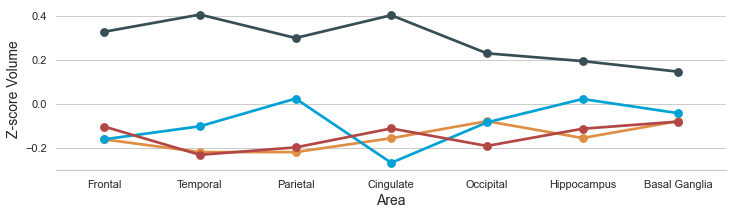

In [170]:
drawAtrophyDf = pd.melt(AtrophyDf,id_vars=['Subtype'])
plt.figure(figsize=[12,3])
sns.set_theme(style="whitegrid")
ax = sns.pointplot(x='variable',y='value',hue='Subtype',data=drawAtrophyDf,ci=None,palette = sns.color_palette(["#374E55FF","#DF8F44FF","#00A1D5FF","#B24745FF"]),legend=False)
sns.despine(left=True)
ax.get_legend().remove()
ax.set_xlabel('Area',fontsize=14)
ax.set_ylabel('Z-score Volume',fontsize=14)
plt.savefig('./DrawGMV/lineCompare.svg',dpi=300,bbox_inches='tight')

统计

In [90]:
from stats import oneway_Anova
columns = ['Frontal','Temporal','Parietal','Cingulate','Occipital','Hippocampus','BG']
resData = pd.DataFrame(
        columns=['Item', 'F', 'P', 'ST1-2T', 'ST1-2P', 'ST1-3T', 'ST1-3P', 'ST1-4T', 'ST1-4P', 'ST2-3T', 'ST2-3P',
                 'ST2-4T', 'ST2-4P', 'ST3-4T', 'ST3-4P'])
AtrophyDf['BG'] = AtrophyDf['Basal Ganglia']
AtrophyDf['Subtype'] = AtrophyDf['Subtype'].astype('int64')+1
AtrophyDf['Subtype'] = AtrophyDf['Subtype'].astype('object')
for c in columns:
    resultsDict = {}
    res = oneway_Anova(AtrophyDf,c,'Subtype')
    resultsDict['Item'] = c
    resultsDict['F'] = res.loc['Subtype','F']
    resultsDict['P'] = res.loc['Subtype','PR(>F)']

    print('====================================================')
    print(res)
    for c1 in [1,2,3]:
        for c2 in range(c1+1,5):
            t,p = scipy.stats.ttest_ind(AtrophyDf.loc[AtrophyDf['Subtype']== c1,c],
                                        AtrophyDf.loc[AtrophyDf['Subtype']== c2,c])

            resultsDict['ST%d-%dT' % (c1,c2)] = t
            resultsDict['ST%d-%dP' % (c1,c2)] = p
    
    resData = resData.append(pd.DataFrame(resultsDict,index=[0]))
    print(resData)
    print('====================================================')
resData.to_csv('table/RegionalGMV_ANOVA2.csv')

Frontal~Subtype
             df      sum_sq   mean_sq         F    PR(>F)
Subtype     3.0   18.111355  6.037118  6.274495  0.000366
Residual  373.0  358.888645  0.962168       NaN       NaN
      Item         F         P    ST1-2T    ST1-2P    ST1-3T    ST1-3P  \
0  Frontal  6.274495  0.000366  3.893297  0.000129  3.355901  0.000947   

     ST1-4T    ST1-4P    ST2-3T    ST2-3P    ST2-4T    ST2-4P    ST3-4T  \
0  2.423349  0.016421 -0.075208  0.940124 -0.522103  0.602263 -0.411401   

     ST3-4P  
0  0.681417  
Temporal~Subtype
             df      sum_sq   mean_sq          F    PR(>F)
Subtype     3.0   28.460707  9.486902  10.152699  0.000002
Residual  373.0  348.539293  0.934422        NaN       NaN
       Item          F         P    ST1-2T    ST1-2P    ST1-3T    ST1-3P  \
0   Frontal   6.274495  0.000366  3.893297  0.000129  3.355901  0.000947   
0  Temporal  10.152699  0.000002  5.021869  0.000001  3.821435  0.000177   

     ST1-4T    ST1-4P    ST2-3T    ST2-3P    ST2-4T    ST2-

In [66]:
AtrophyDf['Subtype'][0]==2

False

In [68]:
AtrophyDf.loc[AtrophyDf['Subtype']== c2,c]

3      1.469414
5      1.942176
9     -0.725093
10    -0.452472
13     0.503523
         ...   
360   -1.226208
363   -0.399239
364   -1.150714
369   -1.878382
373    0.902576
Name: BG, Length: 120, dtype: float64

In [61]:
sns.lineplot(x='Area',y='Atrophy',hue='Subtype',data=AtrophyDf)

ValueError: Could not interpret value `Atrophy` for parameter `y`

In [ ]:
Regional_volume_Df = pd.DataFrame(columns=['Subtype','Atrophy','Area'])
for i in range(4):
    ts = []
    for j,name in enumerate(names):
        ts.append(scipy.stats.ttest_ind(Regional_volume[AD_Cluster==i,j],NC_Regional_volume[:,j])[0])
        AtrophyDf = AtrophyDf.append(pd.DataFrame(dict(Subtype='ST'+str(i+1),Atrophy=ts[-1],Area=name),index=[0]))
    for t in ts:
        print(t,end=',')
    print()

In [154]:
for i in range(4):
    GMV_Res = np.zeros([274])
    for j in range(274):
        AD_NC_Info['GMV'] = AD_NC_GMV[:,j]
        res = smf.ols('GMV~C(GROUP)+AGE+GENDER+TIV',data=AD_NC_Info).fit()
        print(res.tvalues)

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Intercept         3.116999
C(GROUP)[T.3]    -7.120282
AGE              -2.225007
GENDER            1.393338
TIV              19.375479
dtype: float64
Intercept         5.077310
C(GROUP)[T.3]    -7.041311
AGE              -0.014507
GENDER           -1.598110
TIV              14.543256
dtype: float64
Intercept         2.201501
C(GROUP)[T.3]    -8.946905
AGE              -1.006750
GENDER            3.129154
TIV              16.263892
dtype: float64
Intercept         1.050991
C(GROUP)[T.3]    -8.744865
AGE               0.034420
GENDER            1.652450
TIV              15.972131
dtype: float64
Intercept         5.748082
C(GROUP)[T.3]    -8.353990
AGE               0.936391
GENDER           -0.875314
TIV              12.310114
dtype: float64
Intercept         4.859658
C(GROUP)[T.3]    -7.322177
AGE               0.922482
GENDER           -1.631781
TIV              13.051529
dtype: float64
Intercept         2.205506
C(GROUP)[T.3]    -6.218685
AGE              -1.095611
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         5.008431
C(GROUP)[T.3]    -7.988091
AGE              -3.182209
GENDER           -0.183210
TIV              15.815827
dtype: float64
Intercept         6.843787
C(GROUP)[T.3]    -8.551030
AGE              -1.132146
GENDER            0.280909
TIV              15.041389
dtype: float64
Intercept         4.718590
C(GROUP)[T.3]    -7.446726
AGE              -0.567823
GENDER           -0.493282
TIV              15.151379
dtype: float64
Intercept         4.532425
C(GROUP)[T.3]   -12.668491
AGE              -0.309931
GENDER            0.751003
TIV              15.193884
dtype: float64
Intercept         2.736513
C(GROUP)[T.3]    -9.903184
AGE              -1.986038
GENDER            2.091841
TIV              17.509605
dtype: float64
Intercept         2.655941
C(GROUP)[T.3]   -11.550056
AGE              -1.543546
GENDER            2.583305
TIV              14.818696
dtype: float64
Intercept         2.585341
C(GROUP)[T.3]    -9.175078
AGE              -1.202037
GENDER            1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         0.293177
C(GROUP)[T.3]    -6.129494
AGE              -0.620726
GENDER            1.438966
TIV              17.105462
dtype: float64
Intercept         3.322424
C(GROUP)[T.3]    -8.784004
AGE              -0.483679
GENDER           -1.193671
TIV              12.240237
dtype: float64
Intercept         2.188192
C(GROUP)[T.3]    -7.697014
AGE              -1.012673
GENDER           -0.478869
TIV              13.797898
dtype: float64
Intercept         3.802079
C(GROUP)[T.3]    -7.875857
AGE              -0.658168
GENDER            2.694578
TIV              15.898175
dtype: float64
Intercept         3.585790
C(GROUP)[T.3]    -9.008474
AGE              -3.202688
GENDER            3.738222
TIV              19.981794
dtype: float64
Intercept         4.071326
C(GROUP)[T.3]    -9.092219
AGE              -2.600697
GENDER            2.765000
TIV              10.343263
dtype: float64
Intercept         2.748654
C(GROUP)[T.3]    -7.311853
AGE              -2.082960
GENDER            2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         5.690612
C(GROUP)[T.3]    -7.935880
AGE              -4.919372
GENDER            1.460140
TIV              18.157370
dtype: float64
Intercept         6.142672
C(GROUP)[T.3]    -7.508896
AGE              -4.138694
GENDER            1.098512
TIV              16.132227
dtype: float64
Intercept         9.317892
C(GROUP)[T.3]   -16.031227
AGE              -9.152189
GENDER            0.900406
TIV              16.318383
dtype: float64
Intercept         7.255196
C(GROUP)[T.3]   -14.360178
AGE             -10.129247
GENDER            3.471177
TIV              17.600040
dtype: float64
Intercept         7.063621
C(GROUP)[T.3]   -10.466543
AGE              -2.557264
GENDER            0.386497
TIV              13.325710
dtype: float64
Intercept         6.292222
C(GROUP)[T.3]    -9.890562
AGE              -4.544718
GENDER            1.199247
TIV              14.798186
dtype: float64
Intercept         9.873254
C(GROUP)[T.3]    -6.537127
AGE              -7.430390
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.168963
C(GROUP)[T.3]    -2.467599
AGE             -10.210375
GENDER            2.908414
TIV              12.294003
dtype: float64
Intercept         5.774120
C(GROUP)[T.3]    -1.649297
AGE              -6.809327
GENDER           -0.596555
TIV              10.254577
dtype: float64
Intercept         5.414244
C(GROUP)[T.3]    -1.895577
AGE              -6.044239
GENDER           -0.522122
TIV              10.777725
dtype: float64
Intercept        8.770781
C(GROUP)[T.3]   -5.566377
AGE             -0.069392
GENDER          -4.465660
TIV              7.039693
dtype: float64
Intercept         5.982650
C(GROUP)[T.3]    -4.964748
AGE              -1.352730
GENDER           -1.627541
TIV              12.586346
dtype: float64
Intercept         6.586344
C(GROUP)[T.3]   -12.516515
AGE              -2.244317
GENDER            0.292375
TIV              11.968707
dtype: float64
Intercept         4.071889
C(GROUP)[T.3]    -9.530109
AGE              -3.323207
GENDER            3.0573

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.723347
C(GROUP)[T.3]    -4.750138
AGE              -5.919960
GENDER           -0.864671
TIV              10.700720
dtype: float64
Intercept         9.240572
C(GROUP)[T.3]   -15.734019
AGE              -7.737047
GENDER           -1.250261
TIV               9.465901
dtype: float64
Intercept        11.207707
C(GROUP)[T.3]   -16.813303
AGE              -7.706736
GENDER           -2.459147
TIV               7.659462
dtype: float64
Intercept         3.122740
C(GROUP)[T.3]   -10.642271
AGE              -4.700709
GENDER            0.466110
TIV              14.622299
dtype: float64
Intercept         3.790228
C(GROUP)[T.3]   -11.527521
AGE              -6.004257
GENDER            2.808671
TIV              16.078855
dtype: float64
Intercept         9.615224
C(GROUP)[T.3]   -13.898533
AGE              -7.583913
GENDER           -0.313313
TIV              12.904013
dtype: float64
Intercept        11.017603
C(GROUP)[T.3]   -13.884859
AGE              -8.042108
GENDER           -1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        10.768722
C(GROUP)[T.3]   -13.896633
AGE              -7.211708
GENDER           -1.478818
TIV              11.059117
dtype: float64
Intercept         6.582111
C(GROUP)[T.3]   -13.240266
AGE              -3.285536
GENDER            0.206165
TIV              12.484054
dtype: float64
Intercept         8.500955
C(GROUP)[T.3]   -11.509893
AGE               1.794085
GENDER           -4.554794
TIV               3.846684
dtype: float64
Intercept         5.391995
C(GROUP)[T.3]   -14.668406
AGE              -0.276966
GENDER           -1.294397
TIV               9.722212
dtype: float64
Intercept         3.735350
C(GROUP)[T.3]   -14.499338
AGE              -4.889751
GENDER            2.397411
TIV              14.263328
dtype: float64
Intercept         7.367246
C(GROUP)[T.3]   -13.499510
AGE              -5.841531
GENDER           -2.317819
TIV              10.815648
dtype: float64
Intercept         7.395499
C(GROUP)[T.3]   -14.986161
AGE              -8.973890
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.917454
C(GROUP)[T.3]    -9.791744
AGE              -6.642924
GENDER           -0.265311
TIV              12.196890
dtype: float64
Intercept         3.096902
C(GROUP)[T.3]   -13.893063
AGE              -1.788306
GENDER            1.523997
TIV              11.179604
dtype: float64
Intercept         1.332797
C(GROUP)[T.3]   -10.736599
AGE              -1.588057
GENDER            1.060067
TIV              13.166326
dtype: float64
Intercept         7.874621
C(GROUP)[T.3]   -14.493018
AGE              -7.453221
GENDER           -2.559521
TIV              11.290983
dtype: float64
Intercept         5.922309
C(GROUP)[T.3]   -12.813600
AGE             -10.015678
GENDER            2.073587
TIV              12.710895
dtype: float64
Intercept         6.870569
C(GROUP)[T.3]   -15.547215
AGE              -7.561794
GENDER            0.414018
TIV              10.329991
dtype: float64
Intercept         6.237796
C(GROUP)[T.3]   -13.813970
AGE              -8.642069
GENDER            2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         2.237375
C(GROUP)[T.3]   -11.125339
AGE              -4.644180
GENDER            2.079671
TIV              14.910464
dtype: float64
Intercept         9.143710
C(GROUP)[T.3]   -20.167411
AGE              -9.414940
GENDER           -0.185982
TIV              12.123330
dtype: float64
Intercept         8.888881
C(GROUP)[T.3]   -18.909357
AGE             -10.785667
GENDER            0.010100
TIV              13.231717
dtype: float64
Intercept         8.507055
C(GROUP)[T.3]   -14.346538
AGE              -4.334489
GENDER           -0.831888
TIV              11.205447
dtype: float64
Intercept         7.853858
C(GROUP)[T.3]   -14.081086
AGE              -6.752746
GENDER           -0.510976
TIV              14.335120
dtype: float64
Intercept         5.521568
C(GROUP)[T.3]   -18.613687
AGE              -4.709882
GENDER            1.074070
TIV              12.789811
dtype: float64
Intercept         6.304242
C(GROUP)[T.3]   -16.880551
AGE              -3.878150
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        13.600426
C(GROUP)[T.3]   -16.495918
AGE              -7.035657
GENDER           -4.051473
TIV               0.049463
dtype: float64
Intercept         4.582900
C(GROUP)[T.3]   -15.119329
AGE              -3.645444
GENDER           -1.571738
TIV               9.778388
dtype: float64
Intercept         6.111257
C(GROUP)[T.3]   -13.548755
AGE              -3.202088
GENDER           -3.954858
TIV               8.079654
dtype: float64
Intercept         8.506969
C(GROUP)[T.3]   -19.730396
AGE              -6.387178
GENDER           -0.755620
TIV               8.087064
dtype: float64
Intercept         5.108272
C(GROUP)[T.3]   -13.828894
AGE              -7.198362
GENDER           -0.314580
TIV               9.577761
dtype: float64
Intercept        6.455349
C(GROUP)[T.3]   -8.928065
AGE              0.650245
GENDER           0.584957
TIV              4.471766
dtype: float64
Intercept        7.364412
C(GROUP)[T.3]   -8.308915
AGE              1.484133
GENDER          -1.618685
T

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         0.613446
C(GROUP)[T.3]    -8.429481
AGE              -0.815962
GENDER            1.452608
TIV              16.281913
dtype: float64
Intercept         2.338396
C(GROUP)[T.3]    -7.737245
AGE              -1.915742
GENDER            1.463046
TIV              14.163486
dtype: float64
Intercept         0.991941
C(GROUP)[T.3]    -9.736604
AGE              -2.609873
GENDER            2.311738
TIV              17.281047
dtype: float64
Intercept         2.632213
C(GROUP)[T.3]    -9.566980
AGE              -1.355863
GENDER            0.429098
TIV              14.273657
dtype: float64
Intercept         3.037448
C(GROUP)[T.3]    -8.626502
AGE              -2.810148
GENDER            3.769427
TIV              10.819473
dtype: float64
Intercept        3.538588
C(GROUP)[T.3]   -6.542095
AGE             -1.048027
GENDER           2.565109
TIV              7.844892
dtype: float64
Intercept         1.969849
C(GROUP)[T.3]    -6.174563
AGE              -2.949633
GENDER            2.9454

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         0.446950
C(GROUP)[T.3]   -12.772165
AGE               0.714912
GENDER            3.769551
TIV              14.908351
dtype: float64
Intercept         0.939376
C(GROUP)[T.3]   -11.150792
AGE              -1.151834
GENDER            3.461961
TIV              15.931850
dtype: float64
Intercept         5.546148
C(GROUP)[T.3]   -12.730668
AGE              -2.860296
GENDER            2.492188
TIV              11.992379
dtype: float64
Intercept         4.186447
C(GROUP)[T.3]   -11.161450
AGE              -2.604060
GENDER            4.926555
TIV              11.773108
dtype: float64
Intercept         4.110343
C(GROUP)[T.3]   -13.761891
AGE              -1.292325
GENDER            1.644239
TIV              12.987956
dtype: float64
Intercept         2.347422
C(GROUP)[T.3]   -11.358866
AGE              -2.662667
GENDER            1.623058
TIV              14.619118
dtype: float64
Intercept         3.928085
C(GROUP)[T.3]   -16.466320
AGE              -2.666176
GENDER            3

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         1.753478
C(GROUP)[T.3]    -9.743926
AGE               0.804620
GENDER            0.993246
TIV              12.848066
dtype: float64
Intercept         2.266284
C(GROUP)[T.3]    -8.448797
AGE               1.719964
GENDER            0.376491
TIV              13.918798
dtype: float64
Intercept         3.331075
C(GROUP)[T.3]    -8.443781
AGE               1.725235
GENDER           -0.460517
TIV              11.634651
dtype: float64
Intercept         4.957144
C(GROUP)[T.3]   -12.416440
AGE              -2.064070
GENDER           -0.628999
TIV              11.333632
dtype: float64
Intercept         3.914607
C(GROUP)[T.3]   -12.122063
AGE              -3.822603
GENDER            1.235073
TIV              14.510483
dtype: float64
Intercept         2.499133
C(GROUP)[T.3]   -14.971089
AGE               1.233053
GENDER            0.710796
TIV              12.100593
dtype: float64
Intercept         1.055887
C(GROUP)[T.3]   -14.253742
AGE              -0.558384
GENDER            3

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.032467
C(GROUP)[T.3]    -6.820349
AGE              -5.397580
GENDER            1.329714
TIV              14.485100
dtype: float64
Intercept         5.876788
C(GROUP)[T.3]    -8.792021
AGE              -4.158898
GENDER            3.706621
TIV              11.517048
dtype: float64
Intercept         5.435689
C(GROUP)[T.3]    -7.820875
AGE              -6.602770
GENDER            3.535365
TIV              13.347182
dtype: float64
Intercept         4.749671
C(GROUP)[T.3]    -2.492520
AGE              -5.806808
GENDER            1.045442
TIV              13.249715
dtype: float64
Intercept         4.223522
C(GROUP)[T.3]    -3.347910
AGE              -5.207449
GENDER            0.536254
TIV              14.650826
dtype: float64
Intercept         7.178328
C(GROUP)[T.3]   -11.162532
AGE              -8.698552
GENDER            2.601358
TIV              17.787764
dtype: float64
Intercept         7.103027
C(GROUP)[T.3]   -10.195101
AGE              -7.179097
GENDER            2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        10.734051
C(GROUP)[T.3]   -10.634485
AGE              -1.998308
GENDER           -0.158774
TIV              11.575894
dtype: float64
Intercept         6.702312
C(GROUP)[T.3]    -7.437918
AGE              -3.878362
GENDER            1.984876
TIV              14.641221
dtype: float64
Intercept         7.900898
C(GROUP)[T.3]   -10.647833
AGE              -4.400872
GENDER            0.792482
TIV              14.270566
dtype: float64
Intercept         9.518007
C(GROUP)[T.3]    -9.270024
AGE              -4.880792
GENDER           -0.072972
TIV              12.263103
dtype: float64
Intercept         9.208097
C(GROUP)[T.3]   -12.510576
AGE              -0.687555
GENDER           -2.054171
TIV               8.746280
dtype: float64
Intercept         9.658527
C(GROUP)[T.3]   -11.658438
AGE              -2.728343
GENDER           -2.030695
TIV               9.495266
dtype: float64
Intercept         3.741968
C(GROUP)[T.3]   -16.072618
AGE               0.684827
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         9.453681
C(GROUP)[T.3]   -10.477093
AGE              -6.625228
GENDER            1.556630
TIV               9.602020
dtype: float64
Intercept         6.911229
C(GROUP)[T.3]   -11.415457
AGE               0.763555
GENDER           -5.300140
TIV               9.768496
dtype: float64
Intercept         4.878939
C(GROUP)[T.3]   -11.062406
AGE              -0.096036
GENDER           -2.065077
TIV              13.106435
dtype: float64
Intercept         6.346091
C(GROUP)[T.3]    -9.333707
AGE              -6.247030
GENDER            1.283302
TIV              13.885658
dtype: float64
Intercept        8.711590
C(GROUP)[T.3]   -7.400919
AGE             -5.189570
GENDER          -0.096557
TIV              8.764889
dtype: float64
Intercept         5.550673
C(GROUP)[T.3]   -12.163463
AGE              -2.810017
GENDER            0.216394
TIV              13.551601
dtype: float64
Intercept         6.029419
C(GROUP)[T.3]   -13.544919
AGE              -3.340690
GENDER            1.2705

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        9.994949
C(GROUP)[T.3]   -6.543696
AGE             -9.694613
GENDER           0.794992
TIV              9.915817
dtype: float64
Intercept         2.610221
C(GROUP)[T.3]    -5.032288
AGE              -6.312935
GENDER            2.977719
TIV              12.439906
dtype: float64
Intercept         6.242717
C(GROUP)[T.3]    -5.443865
AGE              -7.811129
GENDER            0.797416
TIV              10.792432
dtype: float64
Intercept         8.946733
C(GROUP)[T.3]   -12.951012
AGE              -2.178513
GENDER           -0.526442
TIV               8.526143
dtype: float64
Intercept        10.585014
C(GROUP)[T.3]   -11.837972
AGE              -3.434198
GENDER           -1.665603
TIV               8.296603
dtype: float64
Intercept         7.071136
C(GROUP)[T.3]    -8.635744
AGE              -7.650410
GENDER            1.043126
TIV              12.420957
dtype: float64
Intercept         6.520760
C(GROUP)[T.3]    -7.733247
AGE              -8.389613
GENDER            2.3235

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         0.590344
C(GROUP)[T.3]    -6.185524
AGE              -5.010607
GENDER            3.099853
TIV              16.111353
dtype: float64
Intercept         1.226425
C(GROUP)[T.3]    -6.219200
AGE              -5.223377
GENDER            1.987595
TIV              16.323558
dtype: float64
Intercept         2.592156
C(GROUP)[T.3]    -9.326102
AGE              -4.236185
GENDER            1.292287
TIV              16.002896
dtype: float64
Intercept         1.959015
C(GROUP)[T.3]    -9.119135
AGE              -4.230598
GENDER            0.945302
TIV              16.742768
dtype: float64
Intercept         2.796803
C(GROUP)[T.3]    -7.652494
AGE              -4.516383
GENDER            3.332295
TIV              13.418725
dtype: float64
Intercept         4.332308
C(GROUP)[T.3]    -6.343401
AGE              -5.394850
GENDER            2.422814
TIV              13.657422
dtype: float64
Intercept         2.061607
C(GROUP)[T.3]   -10.710756
AGE              -6.470744
GENDER            5

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        11.203095
C(GROUP)[T.3]   -26.898900
AGE              -7.970633
GENDER           -1.650902
TIV               9.769103
dtype: float64
Intercept        11.011199
C(GROUP)[T.3]   -25.418151
AGE              -8.687246
GENDER           -1.553774
TIV              11.112118
dtype: float64
Intercept         9.925709
C(GROUP)[T.3]   -24.650031
AGE              -8.454173
GENDER            1.092838
TIV               7.822336
dtype: float64
Intercept         9.944902
C(GROUP)[T.3]   -25.863084
AGE              -9.871393
GENDER            1.849627
TIV               9.491792
dtype: float64
Intercept         2.644702
C(GROUP)[T.3]    -5.624969
AGE               0.954448
GENDER            2.394715
TIV              11.824222
dtype: float64
Intercept         4.881464
C(GROUP)[T.3]    -6.365896
AGE              -0.174788
GENDER            0.462884
TIV              11.040795
dtype: float64
Intercept        5.192188
C(GROUP)[T.3]   -4.911640
AGE              1.298291
GENDER          -0.496

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept       -1.720265
C(GROUP)[T.3]   -0.387829
AGE              2.437395
GENDER           3.967549
TIV              8.260385
dtype: float64
Intercept        1.181744
C(GROUP)[T.3]   -1.373991
AGE              4.587191
GENDER           0.667263
TIV              5.713498
dtype: float64
Intercept        6.162147
C(GROUP)[T.3]   -6.054575
AGE              4.274369
GENDER          -1.580761
TIV              3.801893
dtype: float64
Intercept        3.821516
C(GROUP)[T.3]   -4.929263
AGE              2.365801
GENDER           0.055243
TIV              8.103002
dtype: float64
Intercept         4.873539
C(GROUP)[T.3]   -10.496225
AGE              -2.463858
GENDER            4.976749
TIV              10.031877
dtype: float64
Intercept         9.328332
C(GROUP)[T.3]   -11.070524
AGE              -4.368997
GENDER            2.556532
TIV               5.806734
dtype: float64
Intercept        0.682486
C(GROUP)[T.3]   -2.229341
AGE             -6.441785
GENDER           2.264522
TIV             

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        10.084507
C(GROUP)[T.3]   -12.936618
AGE              -7.615255
GENDER            4.508675
TIV               3.717705
dtype: float64
Intercept         5.814243
C(GROUP)[T.3]   -11.317027
AGE               0.311538
GENDER            3.258379
TIV               6.576017
dtype: float64
Intercept         9.588811
C(GROUP)[T.3]   -10.770139
AGE              -7.308638
GENDER            2.902500
TIV               7.400214
dtype: float64
Intercept         8.018309
C(GROUP)[T.3]   -14.877542
AGE              -4.292276
GENDER            3.214095
TIV               4.325832
dtype: float64
Intercept        11.238067
C(GROUP)[T.3]   -15.037534
AGE              -6.893023
GENDER            2.147970
TIV               5.204473
dtype: float64
Intercept         7.408860
C(GROUP)[T.3]   -12.679105
AGE              -0.215072
GENDER            2.302787
TIV               5.090534
dtype: float64
Intercept        10.788035
C(GROUP)[T.3]    -8.770792
AGE               0.821976
GENDER           -3

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        11.235683
C(GROUP)[T.3]    -1.046161
AGE              -1.769482
GENDER           -3.595801
TIV               5.577879
dtype: float64
Intercept        12.459829
C(GROUP)[T.3]    -2.211918
AGE              -6.144688
GENDER           -2.475333
TIV              10.248426
dtype: float64
Intercept        13.364912
C(GROUP)[T.3]    -3.427867
AGE              -6.667928
GENDER           -3.268797
TIV               9.908060
dtype: float64
Intercept        13.558568
C(GROUP)[T.3]    -5.802057
AGE              -9.759926
GENDER           -0.660846
TIV              10.860641
dtype: float64
Intercept        8.333914
C(GROUP)[T.3]   -2.103139
AGE             -0.937169
GENDER           0.538816
TIV              8.154187
dtype: float64
Intercept        13.342080
C(GROUP)[T.3]    -6.237582
AGE              -8.618208
GENDER           -1.819372
TIV               9.747179
dtype: float64
Intercept         9.679610
C(GROUP)[T.3]    -5.611138
AGE              -8.998363
GENDER           -0.6014

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.715785
C(GROUP)[T.3]    -3.403680
AGE              -7.465730
GENDER            1.669849
TIV              11.695390
dtype: float64
Intercept        12.643782
C(GROUP)[T.3]    -4.233752
AGE              -5.304164
GENDER           -2.241576
TIV               0.141944
dtype: float64
Intercept         6.676070
C(GROUP)[T.3]    -3.029489
AGE              -7.859864
GENDER            1.563542
TIV              12.583888
dtype: float64
Intercept         8.310986
C(GROUP)[T.3]    -2.045322
AGE              -5.511581
GENDER           -1.203130
TIV              11.492496
dtype: float64
Intercept        13.233132
C(GROUP)[T.3]    -3.802761
AGE              -5.915365
GENDER           -2.860998
TIV               3.531509
dtype: float64
Intercept         6.152857
C(GROUP)[T.3]    -2.405657
AGE              -5.879717
GENDER            0.868978
TIV              12.895358
dtype: float64
Intercept         8.034046
C(GROUP)[T.3]    -1.869107
AGE              -4.935372
GENDER           -1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        8.269497
C(GROUP)[T.3]   -2.763053
AGE             -6.467125
GENDER          -0.472767
TIV              8.719997
dtype: float64
Intercept        7.987096
C(GROUP)[T.3]   -0.997472
AGE              2.661221
GENDER          -3.635758
TIV             -3.653386
dtype: float64
Intercept        10.141339
C(GROUP)[T.3]    -3.372168
AGE              -7.230094
GENDER           -1.931965
TIV               6.790913
dtype: float64
Intercept         3.116999
C(GROUP)[T.3]    -7.120282
AGE              -2.225007
GENDER            1.393338
TIV              19.375479
dtype: float64
Intercept         5.077310
C(GROUP)[T.3]    -7.041311
AGE              -0.014507
GENDER           -1.598110
TIV              14.543256
dtype: float64
Intercept         2.201501
C(GROUP)[T.3]    -8.946905
AGE              -1.006750
GENDER            3.129154
TIV              16.263892
dtype: float64
Intercept         1.050991
C(GROUP)[T.3]    -8.744865
AGE               0.034420
GENDER            1.652450
TI

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         5.258972
C(GROUP)[T.3]    -7.264736
AGE              -3.409437
GENDER           -0.337770
TIV              17.237510
dtype: float64
Intercept         5.913703
C(GROUP)[T.3]    -6.922201
AGE              -2.456343
GENDER           -1.481367
TIV              15.743022
dtype: float64
Intercept         5.751152
C(GROUP)[T.3]    -8.736998
AGE              -2.699117
GENDER           -0.619530
TIV              16.518235
dtype: float64
Intercept         5.008431
C(GROUP)[T.3]    -7.988091
AGE              -3.182209
GENDER           -0.183210
TIV              15.815827
dtype: float64
Intercept         6.843787
C(GROUP)[T.3]    -8.551030
AGE              -1.132146
GENDER            0.280909
TIV              15.041389
dtype: float64
Intercept         4.718590
C(GROUP)[T.3]    -7.446726
AGE              -0.567823
GENDER           -0.493282
TIV              15.151379
dtype: float64
Intercept         4.532425
C(GROUP)[T.3]   -12.668491
AGE              -0.309931
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         6.077459
C(GROUP)[T.3]   -11.057129
AGE              -1.809545
GENDER            1.406256
TIV              13.816023
dtype: float64
Intercept         3.125630
C(GROUP)[T.3]   -10.878734
AGE              -0.559187
GENDER            1.639048
TIV              15.470440
dtype: float64
Intercept         3.023108
C(GROUP)[T.3]   -10.444453
AGE              -1.373412
GENDER            2.898443
TIV              16.512838
dtype: float64
Intercept         4.163962
C(GROUP)[T.3]   -10.974760
AGE              -0.352121
GENDER           -1.672070
TIV              14.019986
dtype: float64
Intercept         0.293177
C(GROUP)[T.3]    -6.129494
AGE              -0.620726
GENDER            1.438966
TIV              17.105462
dtype: float64
Intercept         3.322424
C(GROUP)[T.3]    -8.784004
AGE              -0.483679
GENDER           -1.193671
TIV              12.240237
dtype: float64
Intercept         2.188192
C(GROUP)[T.3]    -7.697014
AGE              -1.012673
GENDER           -0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.507997
C(GROUP)[T.3]    -9.706203
AGE              -5.173149
GENDER            2.618111
TIV              19.774147
dtype: float64
Intercept         5.522395
C(GROUP)[T.3]   -13.058909
AGE              -4.168521
GENDER            2.060467
TIV              17.972658
dtype: float64
Intercept         7.569700
C(GROUP)[T.3]   -12.601912
AGE              -5.178228
GENDER           -0.029247
TIV              19.036079
dtype: float64
Intercept         5.690612
C(GROUP)[T.3]    -7.935880
AGE              -4.919372
GENDER            1.460140
TIV              18.157370
dtype: float64
Intercept         6.142672
C(GROUP)[T.3]    -7.508896
AGE              -4.138694
GENDER            1.098512
TIV              16.132227
dtype: float64
Intercept         9.317892
C(GROUP)[T.3]   -16.031227
AGE              -9.152189
GENDER            0.900406
TIV              16.318383
dtype: float64
Intercept         7.255196
C(GROUP)[T.3]   -14.360178
AGE             -10.129247
GENDER            3

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.396300
C(GROUP)[T.3]    -8.403316
AGE              -4.488788
GENDER           -0.364406
TIV              14.879335
dtype: float64
Intercept         4.069390
C(GROUP)[T.3]    -7.374631
AGE              -3.732245
GENDER            0.246970
TIV              14.396952
dtype: float64
Intercept         8.540787
C(GROUP)[T.3]    -2.401398
AGE             -10.808573
GENDER            0.361514
TIV              10.770802
dtype: float64
Intercept         7.168963
C(GROUP)[T.3]    -2.467599
AGE             -10.210375
GENDER            2.908414
TIV              12.294003
dtype: float64
Intercept         5.774120
C(GROUP)[T.3]    -1.649297
AGE              -6.809327
GENDER           -0.596555
TIV              10.254577
dtype: float64
Intercept         5.414244
C(GROUP)[T.3]    -1.895577
AGE              -6.044239
GENDER           -0.522122
TIV              10.777725
dtype: float64
Intercept        8.770781
C(GROUP)[T.3]   -5.566377
AGE             -0.069392
GENDER          -4.465

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.115134
C(GROUP)[T.3]    -4.285941
AGE              -5.063760
GENDER           -1.520728
TIV              11.096180
dtype: float64
Intercept         7.723347
C(GROUP)[T.3]    -4.750138
AGE              -5.919960
GENDER           -0.864671
TIV              10.700720
dtype: float64
Intercept         9.240572
C(GROUP)[T.3]   -15.734019
AGE              -7.737047
GENDER           -1.250261
TIV               9.465901
dtype: float64
Intercept        11.207707
C(GROUP)[T.3]   -16.813303
AGE              -7.706736
GENDER           -2.459147
TIV               7.659462
dtype: float64
Intercept         3.122740
C(GROUP)[T.3]   -10.642271
AGE              -4.700709
GENDER            0.466110
TIV              14.622299
dtype: float64
Intercept         3.790228
C(GROUP)[T.3]   -11.527521
AGE              -6.004257
GENDER            2.808671
TIV              16.078855
dtype: float64
Intercept         9.615224
C(GROUP)[T.3]   -13.898533
AGE              -7.583913
GENDER           -0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         6.582111
C(GROUP)[T.3]   -13.240266
AGE              -3.285536
GENDER            0.206165
TIV              12.484054
dtype: float64
Intercept         8.500955
C(GROUP)[T.3]   -11.509893
AGE               1.794085
GENDER           -4.554794
TIV               3.846684
dtype: float64
Intercept         5.391995
C(GROUP)[T.3]   -14.668406
AGE              -0.276966
GENDER           -1.294397
TIV               9.722212
dtype: float64
Intercept         3.735350
C(GROUP)[T.3]   -14.499338
AGE              -4.889751
GENDER            2.397411
TIV              14.263328
dtype: float64
Intercept         7.367246
C(GROUP)[T.3]   -13.499510
AGE              -5.841531
GENDER           -2.317819
TIV              10.815648
dtype: float64
Intercept         7.395499
C(GROUP)[T.3]   -14.986161
AGE              -8.973890
GENDER            0.431876
TIV              13.698135
dtype: float64
Intercept         5.238809
C(GROUP)[T.3]   -12.894802
AGE               0.170229
GENDER           -0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         3.096902
C(GROUP)[T.3]   -13.893063
AGE              -1.788306
GENDER            1.523997
TIV              11.179604
dtype: float64
Intercept         1.332797
C(GROUP)[T.3]   -10.736599
AGE              -1.588057
GENDER            1.060067
TIV              13.166326
dtype: float64
Intercept         7.874621
C(GROUP)[T.3]   -14.493018
AGE              -7.453221
GENDER           -2.559521
TIV              11.290983
dtype: float64
Intercept         5.922309
C(GROUP)[T.3]   -12.813600
AGE             -10.015678
GENDER            2.073587
TIV              12.710895
dtype: float64
Intercept         6.870569
C(GROUP)[T.3]   -15.547215
AGE              -7.561794
GENDER            0.414018
TIV              10.329991
dtype: float64
Intercept         6.237796
C(GROUP)[T.3]   -13.813970
AGE              -8.642069
GENDER            2.133699
TIV              11.735484
dtype: float64
Intercept         3.756395
C(GROUP)[T.3]   -14.832669
AGE              -2.100448
GENDER            2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        12.925313
C(GROUP)[T.3]   -20.797567
AGE              -8.430430
GENDER           -2.123470
TIV               3.204824
dtype: float64
Intercept        13.600426
C(GROUP)[T.3]   -16.495918
AGE              -7.035657
GENDER           -4.051473
TIV               0.049463
dtype: float64
Intercept         4.582900
C(GROUP)[T.3]   -15.119329
AGE              -3.645444
GENDER           -1.571738
TIV               9.778388
dtype: float64
Intercept         6.111257
C(GROUP)[T.3]   -13.548755
AGE              -3.202088
GENDER           -3.954858
TIV               8.079654
dtype: float64
Intercept         8.506969
C(GROUP)[T.3]   -19.730396
AGE              -6.387178
GENDER           -0.755620
TIV               8.087064
dtype: float64
Intercept         5.108272
C(GROUP)[T.3]   -13.828894
AGE              -7.198362
GENDER           -0.314580
TIV               9.577761
dtype: float64
Intercept        6.455349
C(GROUP)[T.3]   -8.928065
AGE              0.650245
GENDER           0.584

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         0.613446
C(GROUP)[T.3]    -8.429481
AGE              -0.815962
GENDER            1.452608
TIV              16.281913
dtype: float64
Intercept         2.338396
C(GROUP)[T.3]    -7.737245
AGE              -1.915742
GENDER            1.463046
TIV              14.163486
dtype: float64
Intercept         0.991941
C(GROUP)[T.3]    -9.736604
AGE              -2.609873
GENDER            2.311738
TIV              17.281047
dtype: float64
Intercept         2.632213
C(GROUP)[T.3]    -9.566980
AGE              -1.355863
GENDER            0.429098
TIV              14.273657
dtype: float64
Intercept         3.037448
C(GROUP)[T.3]    -8.626502
AGE              -2.810148
GENDER            3.769427
TIV              10.819473
dtype: float64
Intercept        3.538588
C(GROUP)[T.3]   -6.542095
AGE             -1.048027
GENDER           2.565109
TIV              7.844892
dtype: float64
Intercept         1.969849
C(GROUP)[T.3]    -6.174563
AGE              -2.949633
GENDER            2.9454

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         0.446950
C(GROUP)[T.3]   -12.772165
AGE               0.714912
GENDER            3.769551
TIV              14.908351
dtype: float64
Intercept         0.939376
C(GROUP)[T.3]   -11.150792
AGE              -1.151834
GENDER            3.461961
TIV              15.931850
dtype: float64
Intercept         5.546148
C(GROUP)[T.3]   -12.730668
AGE              -2.860296
GENDER            2.492188
TIV              11.992379
dtype: float64
Intercept         4.186447
C(GROUP)[T.3]   -11.161450
AGE              -2.604060
GENDER            4.926555
TIV              11.773108
dtype: float64
Intercept         4.110343
C(GROUP)[T.3]   -13.761891
AGE              -1.292325
GENDER            1.644239
TIV              12.987956
dtype: float64
Intercept         2.347422
C(GROUP)[T.3]   -11.358866
AGE              -2.662667
GENDER            1.623058
TIV              14.619118
dtype: float64
Intercept         3.928085
C(GROUP)[T.3]   -16.466320
AGE              -2.666176
GENDER            3

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         2.266284
C(GROUP)[T.3]    -8.448797
AGE               1.719964
GENDER            0.376491
TIV              13.918798
dtype: float64
Intercept         3.331075
C(GROUP)[T.3]    -8.443781
AGE               1.725235
GENDER           -0.460517
TIV              11.634651
dtype: float64
Intercept         4.957144
C(GROUP)[T.3]   -12.416440
AGE              -2.064070
GENDER           -0.628999
TIV              11.333632
dtype: float64
Intercept         3.914607
C(GROUP)[T.3]   -12.122063
AGE              -3.822603
GENDER            1.235073
TIV              14.510483
dtype: float64
Intercept         2.499133
C(GROUP)[T.3]   -14.971089
AGE               1.233053
GENDER            0.710796
TIV              12.100593
dtype: float64
Intercept         1.055887
C(GROUP)[T.3]   -14.253742
AGE              -0.558384
GENDER            3.217253
TIV              14.542658
dtype: float64
Intercept         6.224145
C(GROUP)[T.3]    -5.140474
AGE              -7.774037
GENDER            4

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.032467
C(GROUP)[T.3]    -6.820349
AGE              -5.397580
GENDER            1.329714
TIV              14.485100
dtype: float64
Intercept         5.876788
C(GROUP)[T.3]    -8.792021
AGE              -4.158898
GENDER            3.706621
TIV              11.517048
dtype: float64
Intercept         5.435689
C(GROUP)[T.3]    -7.820875
AGE              -6.602770
GENDER            3.535365
TIV              13.347182
dtype: float64
Intercept         4.749671
C(GROUP)[T.3]    -2.492520
AGE              -5.806808
GENDER            1.045442
TIV              13.249715
dtype: float64
Intercept         4.223522
C(GROUP)[T.3]    -3.347910
AGE              -5.207449
GENDER            0.536254
TIV              14.650826
dtype: float64
Intercept         7.178328
C(GROUP)[T.3]   -11.162532
AGE              -8.698552
GENDER            2.601358
TIV              17.787764
dtype: float64
Intercept         7.103027
C(GROUP)[T.3]   -10.195101
AGE              -7.179097
GENDER            2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        10.403138
C(GROUP)[T.3]   -14.451188
AGE              -2.963605
GENDER           -2.303222
TIV               8.631069
dtype: float64
Intercept        11.025146
C(GROUP)[T.3]   -12.718747
AGE              -3.755842
GENDER           -2.726880
TIV               8.319741
dtype: float64
Intercept        10.734051
C(GROUP)[T.3]   -10.634485
AGE              -1.998308
GENDER           -0.158774
TIV              11.575894
dtype: float64
Intercept         6.702312
C(GROUP)[T.3]    -7.437918
AGE              -3.878362
GENDER            1.984876
TIV              14.641221
dtype: float64
Intercept         7.900898
C(GROUP)[T.3]   -10.647833
AGE              -4.400872
GENDER            0.792482
TIV              14.270566
dtype: float64
Intercept         9.518007
C(GROUP)[T.3]    -9.270024
AGE              -4.880792
GENDER           -0.072972
TIV              12.263103
dtype: float64
Intercept         9.208097
C(GROUP)[T.3]   -12.510576
AGE              -0.687555
GENDER           -2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         6.466005
C(GROUP)[T.3]    -6.325642
AGE              -6.837741
GENDER            0.622369
TIV              11.773903
dtype: float64
Intercept         7.936751
C(GROUP)[T.3]   -12.785732
AGE              -7.221329
GENDER            1.552012
TIV              15.509713
dtype: float64
Intercept         9.453681
C(GROUP)[T.3]   -10.477093
AGE              -6.625228
GENDER            1.556630
TIV               9.602020
dtype: float64
Intercept         6.911229
C(GROUP)[T.3]   -11.415457
AGE               0.763555
GENDER           -5.300140
TIV               9.768496
dtype: float64
Intercept         4.878939
C(GROUP)[T.3]   -11.062406
AGE              -0.096036
GENDER           -2.065077
TIV              13.106435
dtype: float64
Intercept         6.346091
C(GROUP)[T.3]    -9.333707
AGE              -6.247030
GENDER            1.283302
TIV              13.885658
dtype: float64
Intercept        8.711590
C(GROUP)[T.3]   -7.400919
AGE             -5.189570
GENDER          -0.096

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         3.110310
C(GROUP)[T.3]    -8.733864
AGE              -3.991292
GENDER            3.021232
TIV              13.826952
dtype: float64
Intercept         4.175025
C(GROUP)[T.3]    -6.180404
AGE              -6.088857
GENDER            0.024221
TIV              11.882617
dtype: float64
Intercept         7.489976
C(GROUP)[T.3]    -7.868659
AGE              -7.528942
GENDER            1.058579
TIV              10.833286
dtype: float64
Intercept        9.994949
C(GROUP)[T.3]   -6.543696
AGE             -9.694613
GENDER           0.794992
TIV              9.915817
dtype: float64
Intercept         2.610221
C(GROUP)[T.3]    -5.032288
AGE              -6.312935
GENDER            2.977719
TIV              12.439906
dtype: float64
Intercept         6.242717
C(GROUP)[T.3]    -5.443865
AGE              -7.811129
GENDER            0.797416
TIV              10.792432
dtype: float64
Intercept         8.946733
C(GROUP)[T.3]   -12.951012
AGE              -2.178513
GENDER           -0.5264

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.569297
C(GROUP)[T.3]   -12.486298
AGE              -5.930423
GENDER            3.183565
TIV              15.328074
dtype: float64
Intercept         4.039962
C(GROUP)[T.3]   -13.086280
AGE              -3.104426
GENDER            2.128897
TIV              13.814038
dtype: float64
Intercept         3.904449
C(GROUP)[T.3]   -12.843203
AGE              -3.550457
GENDER            1.194597
TIV              14.524359
dtype: float64
Intercept         0.590344
C(GROUP)[T.3]    -6.185524
AGE              -5.010607
GENDER            3.099853
TIV              16.111353
dtype: float64
Intercept         1.226425
C(GROUP)[T.3]    -6.219200
AGE              -5.223377
GENDER            1.987595
TIV              16.323558
dtype: float64
Intercept         2.592156
C(GROUP)[T.3]    -9.326102
AGE              -4.236185
GENDER            1.292287
TIV              16.002896
dtype: float64
Intercept         1.959015
C(GROUP)[T.3]    -9.119135
AGE              -4.230598
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        12.671694
C(GROUP)[T.3]   -23.203675
AGE              -4.393114
GENDER           -4.106498
TIV               4.413227
dtype: float64
Intercept         9.913030
C(GROUP)[T.3]   -23.159444
AGE              -7.746031
GENDER           -1.195327
TIV              11.849052
dtype: float64
Intercept        11.203095
C(GROUP)[T.3]   -26.898900
AGE              -7.970633
GENDER           -1.650902
TIV               9.769103
dtype: float64
Intercept        11.011199
C(GROUP)[T.3]   -25.418151
AGE              -8.687246
GENDER           -1.553774
TIV              11.112118
dtype: float64
Intercept         9.925709
C(GROUP)[T.3]   -24.650031
AGE              -8.454173
GENDER            1.092838
TIV               7.822336
dtype: float64
Intercept         9.944902
C(GROUP)[T.3]   -25.863084
AGE              -9.871393
GENDER            1.849627
TIV               9.491792
dtype: float64
Intercept         2.644702
C(GROUP)[T.3]    -5.624969
AGE               0.954448
GENDER            2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        13.660151
C(GROUP)[T.3]   -18.302857
AGE              -4.863432
GENDER           -3.278101
TIV              11.144112
dtype: float64
Intercept        5.639621
C(GROUP)[T.3]   -4.892619
AGE              0.936572
GENDER          -0.546965
TIV              7.163453
dtype: float64
Intercept        5.681842
C(GROUP)[T.3]   -3.673189
AGE              0.959249
GENDER          -1.078815
TIV              7.417292
dtype: float64
Intercept       -1.720265
C(GROUP)[T.3]   -0.387829
AGE              2.437395
GENDER           3.967549
TIV              8.260385
dtype: float64
Intercept        1.181744
C(GROUP)[T.3]   -1.373991
AGE              4.587191
GENDER           0.667263
TIV              5.713498
dtype: float64
Intercept        6.162147
C(GROUP)[T.3]   -6.054575
AGE              4.274369
GENDER          -1.580761
TIV              3.801893
dtype: float64
Intercept        3.821516
C(GROUP)[T.3]   -4.929263
AGE              2.365801
GENDER           0.055243
TIV              8.10

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        2.599619
C(GROUP)[T.3]   -4.456470
AGE             -0.703543
GENDER           1.529998
TIV              7.193575
dtype: float64
Intercept         1.608207
C(GROUP)[T.3]    -3.130173
AGE              -4.057320
GENDER            2.986883
TIV              12.747693
dtype: float64
Intercept         9.034792
C(GROUP)[T.3]   -16.540026
AGE              -3.681693
GENDER            3.258520
TIV               7.556845
dtype: float64
Intercept        10.084507
C(GROUP)[T.3]   -12.936618
AGE              -7.615255
GENDER            4.508675
TIV               3.717705
dtype: float64
Intercept         5.814243
C(GROUP)[T.3]   -11.317027
AGE               0.311538
GENDER            3.258379
TIV               6.576017
dtype: float64
Intercept         9.588811
C(GROUP)[T.3]   -10.770139
AGE              -7.308638
GENDER            2.902500
TIV               7.400214
dtype: float64
Intercept         8.018309
C(GROUP)[T.3]   -14.877542
AGE              -4.292276
GENDER            3.2140

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.397570
C(GROUP)[T.3]    -7.642283
AGE              -5.980098
GENDER            4.375261
TIV              14.602043
dtype: float64
Intercept        11.352740
C(GROUP)[T.3]    -0.803171
AGE              -1.963600
GENDER           -4.192927
TIV               6.101307
dtype: float64
Intercept        11.235683
C(GROUP)[T.3]    -1.046161
AGE              -1.769482
GENDER           -3.595801
TIV               5.577879
dtype: float64
Intercept        12.459829
C(GROUP)[T.3]    -2.211918
AGE              -6.144688
GENDER           -2.475333
TIV              10.248426
dtype: float64
Intercept        13.364912
C(GROUP)[T.3]    -3.427867
AGE              -6.667928
GENDER           -3.268797
TIV               9.908060
dtype: float64
Intercept        13.558568
C(GROUP)[T.3]    -5.802057
AGE              -9.759926
GENDER           -0.660846
TIV              10.860641
dtype: float64
Intercept        8.333914
C(GROUP)[T.3]   -2.103139
AGE             -0.937169
GENDER           0.538

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         6.120348
C(GROUP)[T.3]    -3.665915
AGE              -8.952736
GENDER            3.442106
TIV              13.661326
dtype: float64
Intercept         7.715785
C(GROUP)[T.3]    -3.403680
AGE              -7.465730
GENDER            1.669849
TIV              11.695390
dtype: float64
Intercept        12.643782
C(GROUP)[T.3]    -4.233752
AGE              -5.304164
GENDER           -2.241576
TIV               0.141944
dtype: float64
Intercept         6.676070
C(GROUP)[T.3]    -3.029489
AGE              -7.859864
GENDER            1.563542
TIV              12.583888
dtype: float64
Intercept         8.310986
C(GROUP)[T.3]    -2.045322
AGE              -5.511581
GENDER           -1.203130
TIV              11.492496
dtype: float64
Intercept        13.233132
C(GROUP)[T.3]    -3.802761
AGE              -5.915365
GENDER           -2.860998
TIV               3.531509
dtype: float64
Intercept         6.152857
C(GROUP)[T.3]    -2.405657
AGE              -5.879717
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        10.257951
C(GROUP)[T.3]    -3.840112
AGE              -4.308955
GENDER           -1.483535
TIV               3.953526
dtype: float64
Intercept        8.269497
C(GROUP)[T.3]   -2.763053
AGE             -6.467125
GENDER          -0.472767
TIV              8.719997
dtype: float64
Intercept        7.987096
C(GROUP)[T.3]   -0.997472
AGE              2.661221
GENDER          -3.635758
TIV             -3.653386
dtype: float64
Intercept        10.141339
C(GROUP)[T.3]    -3.372168
AGE              -7.230094
GENDER           -1.931965
TIV               6.790913
dtype: float64
Intercept         3.116999
C(GROUP)[T.3]    -7.120282
AGE              -2.225007
GENDER            1.393338
TIV              19.375479
dtype: float64
Intercept         5.077310
C(GROUP)[T.3]    -7.041311
AGE              -0.014507
GENDER           -1.598110
TIV              14.543256
dtype: float64
Intercept         2.201501
C(GROUP)[T.3]    -8.946905
AGE              -1.006750
GENDER            3.129154
TI

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         2.205506
C(GROUP)[T.3]    -6.218685
AGE              -1.095611
GENDER            0.613138
TIV              14.332194
dtype: float64
Intercept         1.408973
C(GROUP)[T.3]    -6.523913
AGE              -0.150701
GENDER            0.789855
TIV              16.063790
dtype: float64
Intercept         5.258972
C(GROUP)[T.3]    -7.264736
AGE              -3.409437
GENDER           -0.337770
TIV              17.237510
dtype: float64
Intercept         5.913703
C(GROUP)[T.3]    -6.922201
AGE              -2.456343
GENDER           -1.481367
TIV              15.743022
dtype: float64
Intercept         5.751152
C(GROUP)[T.3]    -8.736998
AGE              -2.699117
GENDER           -0.619530
TIV              16.518235
dtype: float64
Intercept         5.008431
C(GROUP)[T.3]    -7.988091
AGE              -3.182209
GENDER           -0.183210
TIV              15.815827
dtype: float64
Intercept         6.843787
C(GROUP)[T.3]    -8.551030
AGE              -1.132146
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         2.585341
C(GROUP)[T.3]    -9.175078
AGE              -1.202037
GENDER            1.176001
TIV              12.552759
dtype: float64
Intercept         4.794960
C(GROUP)[T.3]   -10.887366
AGE              -0.734910
GENDER            2.335327
TIV              14.296829
dtype: float64
Intercept         6.077459
C(GROUP)[T.3]   -11.057129
AGE              -1.809545
GENDER            1.406256
TIV              13.816023
dtype: float64
Intercept         3.125630
C(GROUP)[T.3]   -10.878734
AGE              -0.559187
GENDER            1.639048
TIV              15.470440
dtype: float64
Intercept         3.023108
C(GROUP)[T.3]   -10.444453
AGE              -1.373412
GENDER            2.898443
TIV              16.512838
dtype: float64
Intercept         4.163962
C(GROUP)[T.3]   -10.974760
AGE              -0.352121
GENDER           -1.672070
TIV              14.019986
dtype: float64
Intercept         0.293177
C(GROUP)[T.3]    -6.129494
AGE              -0.620726
GENDER            1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         3.585790
C(GROUP)[T.3]    -9.008474
AGE              -3.202688
GENDER            3.738222
TIV              19.981794
dtype: float64
Intercept         4.071326
C(GROUP)[T.3]    -9.092219
AGE              -2.600697
GENDER            2.765000
TIV              10.343263
dtype: float64
Intercept         2.748654
C(GROUP)[T.3]    -7.311853
AGE              -2.082960
GENDER            2.315670
TIV              10.844527
dtype: float64
Intercept         3.427415
C(GROUP)[T.3]    -7.766334
AGE              -0.491996
GENDER            2.076841
TIV              13.038983
dtype: float64
Intercept         1.630469
C(GROUP)[T.3]    -8.863421
AGE              -2.908469
GENDER            4.761481
TIV              15.455118
dtype: float64
Intercept        3.952356
C(GROUP)[T.3]   -3.313176
AGE              0.650644
GENDER           0.003749
TIV              7.721908
dtype: float64
Intercept         3.669040
C(GROUP)[T.3]    -5.142179
AGE              -1.945355
GENDER           -0.0015

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         3.280280
C(GROUP)[T.3]    -6.692241
AGE               1.386639
GENDER            0.649283
TIV              10.386837
dtype: float64
Intercept         4.052751
C(GROUP)[T.3]    -7.057547
AGE              -1.032462
GENDER           -0.155702
TIV              10.913361
dtype: float64
Intercept         6.583952
C(GROUP)[T.3]    -9.514784
AGE              -2.676891
GENDER           -0.077361
TIV              11.635806
dtype: float64
Intercept         5.113177
C(GROUP)[T.3]   -12.153124
AGE              -6.320404
GENDER            3.399026
TIV              16.477250
dtype: float64
Intercept         7.238295
C(GROUP)[T.3]    -9.769438
AGE              -4.661818
GENDER            0.744776
TIV              15.174458
dtype: float64
Intercept         4.507997
C(GROUP)[T.3]    -9.706203
AGE              -5.173149
GENDER            2.618111
TIV              19.774147
dtype: float64
Intercept         5.522395
C(GROUP)[T.3]   -13.058909
AGE              -4.168521
GENDER            2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.255196
C(GROUP)[T.3]   -14.360178
AGE             -10.129247
GENDER            3.471177
TIV              17.600040
dtype: float64
Intercept         7.063621
C(GROUP)[T.3]   -10.466543
AGE              -2.557264
GENDER            0.386497
TIV              13.325710
dtype: float64
Intercept         6.292222
C(GROUP)[T.3]    -9.890562
AGE              -4.544718
GENDER            1.199247
TIV              14.798186
dtype: float64
Intercept         9.873254
C(GROUP)[T.3]    -6.537127
AGE              -7.430390
GENDER            0.178985
TIV              10.135710
dtype: float64
Intercept         6.555415
C(GROUP)[T.3]    -3.035274
AGE              -7.547255
GENDER            2.745500
TIV              12.711996
dtype: float64
Intercept         4.396300
C(GROUP)[T.3]    -8.403316
AGE              -4.488788
GENDER           -0.364406
TIV              14.879335
dtype: float64
Intercept         4.069390
C(GROUP)[T.3]    -7.374631
AGE              -3.732245
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        8.770781
C(GROUP)[T.3]   -5.566377
AGE             -0.069392
GENDER          -4.465660
TIV              7.039693
dtype: float64
Intercept         5.982650
C(GROUP)[T.3]    -4.964748
AGE              -1.352730
GENDER           -1.627541
TIV              12.586346
dtype: float64
Intercept         6.586344
C(GROUP)[T.3]   -12.516515
AGE              -2.244317
GENDER            0.292375
TIV              11.968707
dtype: float64
Intercept         4.071889
C(GROUP)[T.3]    -9.530109
AGE              -3.323207
GENDER            3.057389
TIV              14.173536
dtype: float64
Intercept         4.909003
C(GROUP)[T.3]    -5.123914
AGE              -3.781047
GENDER           -0.189902
TIV              12.621031
dtype: float64
Intercept         3.819876
C(GROUP)[T.3]    -8.275771
AGE              -2.905658
GENDER           -0.114373
TIV              13.103935
dtype: float64
Intercept         7.115134
C(GROUP)[T.3]    -4.285941
AGE              -5.063760
GENDER           -1.5207

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         3.790228
C(GROUP)[T.3]   -11.527521
AGE              -6.004257
GENDER            2.808671
TIV              16.078855
dtype: float64
Intercept         9.615224
C(GROUP)[T.3]   -13.898533
AGE              -7.583913
GENDER           -0.313313
TIV              12.904013
dtype: float64
Intercept        11.017603
C(GROUP)[T.3]   -13.884859
AGE              -8.042108
GENDER           -1.018417
TIV              13.353152
dtype: float64
Intercept        5.471524
C(GROUP)[T.3]   -9.833231
AGE              0.121628
GENDER          -1.399011
TIV              8.072313
dtype: float64
Intercept         1.624000
C(GROUP)[T.3]    -8.209906
AGE              -0.140027
GENDER           -0.301756
TIV              14.227701
dtype: float64
Intercept         9.772823
C(GROUP)[T.3]   -13.531420
AGE              -7.376093
GENDER           -1.474635
TIV              10.779060
dtype: float64
Intercept        10.768722
C(GROUP)[T.3]   -13.896633
AGE              -7.211708
GENDER           -1.4788

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.395499
C(GROUP)[T.3]   -14.986161
AGE              -8.973890
GENDER            0.431876
TIV              13.698135
dtype: float64
Intercept         5.238809
C(GROUP)[T.3]   -12.894802
AGE               0.170229
GENDER           -0.919061
TIV               9.391151
dtype: float64
Intercept         2.591418
C(GROUP)[T.3]   -12.900366
AGE              -3.286635
GENDER            1.457622
TIV              14.720681
dtype: float64
Intercept         5.523870
C(GROUP)[T.3]   -18.451065
AGE              -5.663120
GENDER            3.179321
TIV              12.785615
dtype: float64
Intercept         7.724866
C(GROUP)[T.3]   -19.212481
AGE              -5.968230
GENDER            1.750676
TIV              12.540567
dtype: float64
Intercept         7.427514
C(GROUP)[T.3]   -15.819222
AGE              -3.497861
GENDER           -1.078334
TIV               7.964732
dtype: float64
Intercept         4.917454
C(GROUP)[T.3]    -9.791744
AGE              -6.642924
GENDER           -0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         6.237796
C(GROUP)[T.3]   -13.813970
AGE              -8.642069
GENDER            2.133699
TIV              11.735484
dtype: float64
Intercept         3.756395
C(GROUP)[T.3]   -14.832669
AGE              -2.100448
GENDER            2.258475
TIV              12.861461
dtype: float64
Intercept         4.268285
C(GROUP)[T.3]   -14.342852
AGE              -3.694750
GENDER            0.240026
TIV              12.247842
dtype: float64
Intercept         1.910876
C(GROUP)[T.3]   -15.394018
AGE              -3.383874
GENDER            3.701355
TIV              13.602595
dtype: float64
Intercept         1.924301
C(GROUP)[T.3]   -12.350919
AGE              -5.611703
GENDER            3.243421
TIV              13.813667
dtype: float64
Intercept         1.805595
C(GROUP)[T.3]   -12.574953
AGE              -2.963179
GENDER            1.483951
TIV              15.534832
dtype: float64
Intercept         2.237375
C(GROUP)[T.3]   -11.125339
AGE              -4.644180
GENDER            2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         6.304242
C(GROUP)[T.3]   -16.880551
AGE              -3.878150
GENDER            0.033811
TIV              13.028702
dtype: float64
Intercept         8.215373
C(GROUP)[T.3]   -18.886899
AGE              -7.910615
GENDER           -2.185872
TIV               6.804845
dtype: float64
Intercept         8.569584
C(GROUP)[T.3]   -18.211693
AGE              -7.219761
GENDER           -3.801861
TIV               7.030717
dtype: float64
Intercept         9.654081
C(GROUP)[T.3]   -20.471261
AGE              -4.963950
GENDER           -1.021809
TIV               8.665782
dtype: float64
Intercept        11.827633
C(GROUP)[T.3]   -21.656122
AGE              -5.960627
GENDER           -2.495368
TIV               8.337673
dtype: float64
Intercept        12.925313
C(GROUP)[T.3]   -20.797567
AGE              -8.430430
GENDER           -2.123470
TIV               3.204824
dtype: float64
Intercept        13.600426
C(GROUP)[T.3]   -16.495918
AGE              -7.035657
GENDER           -4

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        6.455349
C(GROUP)[T.3]   -8.928065
AGE              0.650245
GENDER           0.584957
TIV              4.471766
dtype: float64
Intercept        7.364412
C(GROUP)[T.3]   -8.308915
AGE              1.484133
GENDER          -1.618685
TIV              2.464841
dtype: float64
Intercept         3.948982
C(GROUP)[T.3]   -13.612493
AGE              -2.407385
GENDER            3.836430
TIV               8.836497
dtype: float64
Intercept         7.234400
C(GROUP)[T.3]   -15.796832
AGE              -3.522849
GENDER            1.002027
TIV               7.445517
dtype: float64
Intercept         3.604863
C(GROUP)[T.3]   -13.202067
AGE              -3.404961
GENDER            4.550498
TIV              10.898894
dtype: float64
Intercept         6.805197
C(GROUP)[T.3]   -12.285570
AGE              -2.312914
GENDER           -0.403411
TIV               9.169804
dtype: float64
Intercept         0.613446
C(GROUP)[T.3]    -8.429481
AGE              -0.815962
GENDER            1.452608
TI

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         1.780865
C(GROUP)[T.3]    -4.434094
AGE              -2.436028
GENDER            2.343512
TIV              12.234343
dtype: float64
Intercept        -0.142267
C(GROUP)[T.3]   -10.473024
AGE              -0.190732
GENDER            3.471409
TIV              14.760078
dtype: float64
Intercept         2.686748
C(GROUP)[T.3]    -8.885137
AGE              -2.525854
GENDER            3.223179
TIV              10.869050
dtype: float64
Intercept         1.607397
C(GROUP)[T.3]   -11.316343
AGE              -1.266430
GENDER            3.652533
TIV              14.931902
dtype: float64
Intercept         2.962575
C(GROUP)[T.3]   -11.686340
AGE              -3.814591
GENDER            2.205850
TIV              16.013951
dtype: float64
Intercept         0.446950
C(GROUP)[T.3]   -12.772165
AGE               0.714912
GENDER            3.769551
TIV              14.908351
dtype: float64
Intercept         0.939376
C(GROUP)[T.3]   -11.150792
AGE              -1.151834
GENDER            3

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         5.447970
C(GROUP)[T.3]   -12.306023
AGE              -2.571712
GENDER           -0.917117
TIV              13.295845
dtype: float64
Intercept         4.855778
C(GROUP)[T.3]   -11.152804
AGE              -4.648231
GENDER            2.715472
TIV              15.462366
dtype: float64
Intercept         0.278051
C(GROUP)[T.3]   -10.072938
AGE              -0.585596
GENDER            2.711592
TIV              14.858409
dtype: float64
Intercept         1.753478
C(GROUP)[T.3]    -9.743926
AGE               0.804620
GENDER            0.993246
TIV              12.848066
dtype: float64
Intercept         2.266284
C(GROUP)[T.3]    -8.448797
AGE               1.719964
GENDER            0.376491
TIV              13.918798
dtype: float64
Intercept         3.331075
C(GROUP)[T.3]    -8.443781
AGE               1.725235
GENDER           -0.460517
TIV              11.634651
dtype: float64
Intercept         4.957144
C(GROUP)[T.3]   -12.416440
AGE              -2.064070
GENDER           -0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         6.146556
C(GROUP)[T.3]    -5.587247
AGE             -11.386912
GENDER            5.764167
TIV              15.341734
dtype: float64
Intercept         6.631848
C(GROUP)[T.3]    -6.770379
AGE              -2.333559
GENDER           -0.683712
TIV              10.805859
dtype: float64
Intercept         7.032467
C(GROUP)[T.3]    -6.820349
AGE              -5.397580
GENDER            1.329714
TIV              14.485100
dtype: float64
Intercept         5.876788
C(GROUP)[T.3]    -8.792021
AGE              -4.158898
GENDER            3.706621
TIV              11.517048
dtype: float64
Intercept         5.435689
C(GROUP)[T.3]    -7.820875
AGE              -6.602770
GENDER            3.535365
TIV              13.347182
dtype: float64
Intercept         4.749671
C(GROUP)[T.3]    -2.492520
AGE              -5.806808
GENDER            1.045442
TIV              13.249715
dtype: float64
Intercept         4.223522
C(GROUP)[T.3]    -3.347910
AGE              -5.207449
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        10.403138
C(GROUP)[T.3]   -14.451188
AGE              -2.963605
GENDER           -2.303222
TIV               8.631069
dtype: float64
Intercept        11.025146
C(GROUP)[T.3]   -12.718747
AGE              -3.755842
GENDER           -2.726880
TIV               8.319741
dtype: float64
Intercept        10.734051
C(GROUP)[T.3]   -10.634485
AGE              -1.998308
GENDER           -0.158774
TIV              11.575894
dtype: float64
Intercept         6.702312
C(GROUP)[T.3]    -7.437918
AGE              -3.878362
GENDER            1.984876
TIV              14.641221
dtype: float64
Intercept         7.900898
C(GROUP)[T.3]   -10.647833
AGE              -4.400872
GENDER            0.792482
TIV              14.270566
dtype: float64
Intercept         9.518007
C(GROUP)[T.3]    -9.270024
AGE              -4.880792
GENDER           -0.072972
TIV              12.263103
dtype: float64
Intercept         9.208097
C(GROUP)[T.3]   -12.510576
AGE              -0.687555
GENDER           -2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.936751
C(GROUP)[T.3]   -12.785732
AGE              -7.221329
GENDER            1.552012
TIV              15.509713
dtype: float64
Intercept         9.453681
C(GROUP)[T.3]   -10.477093
AGE              -6.625228
GENDER            1.556630
TIV               9.602020
dtype: float64
Intercept         6.911229
C(GROUP)[T.3]   -11.415457
AGE               0.763555
GENDER           -5.300140
TIV               9.768496
dtype: float64
Intercept         4.878939
C(GROUP)[T.3]   -11.062406
AGE              -0.096036
GENDER           -2.065077
TIV              13.106435
dtype: float64
Intercept         6.346091
C(GROUP)[T.3]    -9.333707
AGE              -6.247030
GENDER            1.283302
TIV              13.885658
dtype: float64
Intercept        8.711590
C(GROUP)[T.3]   -7.400919
AGE             -5.189570
GENDER          -0.096557
TIV              8.764889
dtype: float64
Intercept         5.550673
C(GROUP)[T.3]   -12.163463
AGE              -2.810017
GENDER            0.2163

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.489976
C(GROUP)[T.3]    -7.868659
AGE              -7.528942
GENDER            1.058579
TIV              10.833286
dtype: float64
Intercept        9.994949
C(GROUP)[T.3]   -6.543696
AGE             -9.694613
GENDER           0.794992
TIV              9.915817
dtype: float64
Intercept         2.610221
C(GROUP)[T.3]    -5.032288
AGE              -6.312935
GENDER            2.977719
TIV              12.439906
dtype: float64
Intercept         6.242717
C(GROUP)[T.3]    -5.443865
AGE              -7.811129
GENDER            0.797416
TIV              10.792432
dtype: float64
Intercept         8.946733
C(GROUP)[T.3]   -12.951012
AGE              -2.178513
GENDER           -0.526442
TIV               8.526143
dtype: float64
Intercept        10.585014
C(GROUP)[T.3]   -11.837972
AGE              -3.434198
GENDER           -1.665603
TIV               8.296603
dtype: float64
Intercept         7.071136
C(GROUP)[T.3]    -8.635744
AGE              -7.650410
GENDER            1.0431

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         3.904449
C(GROUP)[T.3]   -12.843203
AGE              -3.550457
GENDER            1.194597
TIV              14.524359
dtype: float64
Intercept         0.590344
C(GROUP)[T.3]    -6.185524
AGE              -5.010607
GENDER            3.099853
TIV              16.111353
dtype: float64
Intercept         1.226425
C(GROUP)[T.3]    -6.219200
AGE              -5.223377
GENDER            1.987595
TIV              16.323558
dtype: float64
Intercept         2.592156
C(GROUP)[T.3]    -9.326102
AGE              -4.236185
GENDER            1.292287
TIV              16.002896
dtype: float64
Intercept         1.959015
C(GROUP)[T.3]    -9.119135
AGE              -4.230598
GENDER            0.945302
TIV              16.742768
dtype: float64
Intercept         2.796803
C(GROUP)[T.3]    -7.652494
AGE              -4.516383
GENDER            3.332295
TIV              13.418725
dtype: float64
Intercept         4.332308
C(GROUP)[T.3]    -6.343401
AGE              -5.394850
GENDER            2

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        10.894114
C(GROUP)[T.3]   -22.655107
AGE              -4.912683
GENDER           -4.072732
TIV               4.940663
dtype: float64
Intercept        12.671694
C(GROUP)[T.3]   -23.203675
AGE              -4.393114
GENDER           -4.106498
TIV               4.413227
dtype: float64
Intercept         9.913030
C(GROUP)[T.3]   -23.159444
AGE              -7.746031
GENDER           -1.195327
TIV              11.849052
dtype: float64
Intercept        11.203095
C(GROUP)[T.3]   -26.898900
AGE              -7.970633
GENDER           -1.650902
TIV               9.769103
dtype: float64
Intercept        11.011199
C(GROUP)[T.3]   -25.418151
AGE              -8.687246
GENDER           -1.553774
TIV              11.112118
dtype: float64
Intercept         9.925709
C(GROUP)[T.3]   -24.650031
AGE              -8.454173
GENDER            1.092838
TIV               7.822336
dtype: float64
Intercept         9.944902
C(GROUP)[T.3]   -25.863084
AGE              -9.871393
GENDER            1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        2.599619
C(GROUP)[T.3]   -4.456470
AGE             -0.703543
GENDER           1.529998
TIV              7.193575
dtype: float64
Intercept         1.608207
C(GROUP)[T.3]    -3.130173
AGE              -4.057320
GENDER            2.986883
TIV              12.747693
dtype: float64
Intercept         9.034792
C(GROUP)[T.3]   -16.540026
AGE              -3.681693
GENDER            3.258520
TIV               7.556845
dtype: float64
Intercept        10.084507
C(GROUP)[T.3]   -12.936618
AGE              -7.615255
GENDER            4.508675
TIV               3.717705
dtype: float64
Intercept         5.814243
C(GROUP)[T.3]   -11.317027
AGE               0.311538
GENDER            3.258379
TIV               6.576017
dtype: float64
Intercept         9.588811
C(GROUP)[T.3]   -10.770139
AGE              -7.308638
GENDER            2.902500
TIV               7.400214
dtype: float64
Intercept         8.018309
C(GROUP)[T.3]   -14.877542
AGE              -4.292276
GENDER            3.2140

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.397570
C(GROUP)[T.3]    -7.642283
AGE              -5.980098
GENDER            4.375261
TIV              14.602043
dtype: float64
Intercept        11.352740
C(GROUP)[T.3]    -0.803171
AGE              -1.963600
GENDER           -4.192927
TIV               6.101307
dtype: float64
Intercept        11.235683
C(GROUP)[T.3]    -1.046161
AGE              -1.769482
GENDER           -3.595801
TIV               5.577879
dtype: float64
Intercept        12.459829
C(GROUP)[T.3]    -2.211918
AGE              -6.144688
GENDER           -2.475333
TIV              10.248426
dtype: float64
Intercept        13.364912
C(GROUP)[T.3]    -3.427867
AGE              -6.667928
GENDER           -3.268797
TIV               9.908060
dtype: float64
Intercept        13.558568
C(GROUP)[T.3]    -5.802057
AGE              -9.759926
GENDER           -0.660846
TIV              10.860641
dtype: float64
Intercept        8.333914
C(GROUP)[T.3]   -2.103139
AGE             -0.937169
GENDER           0.538

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        8.809141
C(GROUP)[T.3]   -1.839407
AGE             -2.054500
GENDER          -1.029726
TIV              4.839452
dtype: float64
Intercept         6.120348
C(GROUP)[T.3]    -3.665915
AGE              -8.952736
GENDER            3.442106
TIV              13.661326
dtype: float64
Intercept         7.715785
C(GROUP)[T.3]    -3.403680
AGE              -7.465730
GENDER            1.669849
TIV              11.695390
dtype: float64
Intercept        12.643782
C(GROUP)[T.3]    -4.233752
AGE              -5.304164
GENDER           -2.241576
TIV               0.141944
dtype: float64
Intercept         6.676070
C(GROUP)[T.3]    -3.029489
AGE              -7.859864
GENDER            1.563542
TIV              12.583888
dtype: float64
Intercept         8.310986
C(GROUP)[T.3]    -2.045322
AGE              -5.511581
GENDER           -1.203130
TIV              11.492496
dtype: float64
Intercept        13.233132
C(GROUP)[T.3]    -3.802761
AGE              -5.915365
GENDER           -2.8609

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         8.063597
C(GROUP)[T.3]    -2.749743
AGE              -5.096699
GENDER           -0.044346
TIV              10.912936
dtype: float64
Intercept        9.292411
C(GROUP)[T.3]   -3.170146
AGE             -2.834537
GENDER          -2.655290
TIV              3.315575
dtype: float64
Intercept        10.100225
C(GROUP)[T.3]    -3.726549
AGE              -4.143539
GENDER           -0.127308
TIV               2.383099
dtype: float64
Intercept        10.257951
C(GROUP)[T.3]    -3.840112
AGE              -4.308955
GENDER           -1.483535
TIV               3.953526
dtype: float64
Intercept        8.269497
C(GROUP)[T.3]   -2.763053
AGE             -6.467125
GENDER          -0.472767
TIV              8.719997
dtype: float64
Intercept        7.987096
C(GROUP)[T.3]   -0.997472
AGE              2.661221
GENDER          -3.635758
TIV             -3.653386
dtype: float64
Intercept        10.141339
C(GROUP)[T.3]    -3.372168
AGE              -7.230094
GENDER           -1.931965
TIV    

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         2.205506
C(GROUP)[T.3]    -6.218685
AGE              -1.095611
GENDER            0.613138
TIV              14.332194
dtype: float64
Intercept         1.408973
C(GROUP)[T.3]    -6.523913
AGE              -0.150701
GENDER            0.789855
TIV              16.063790
dtype: float64
Intercept         5.258972
C(GROUP)[T.3]    -7.264736
AGE              -3.409437
GENDER           -0.337770
TIV              17.237510
dtype: float64
Intercept         5.913703
C(GROUP)[T.3]    -6.922201
AGE              -2.456343
GENDER           -1.481367
TIV              15.743022
dtype: float64
Intercept         5.751152
C(GROUP)[T.3]    -8.736998
AGE              -2.699117
GENDER           -0.619530
TIV              16.518235
dtype: float64
Intercept         5.008431
C(GROUP)[T.3]    -7.988091
AGE              -3.182209
GENDER           -0.183210
TIV              15.815827
dtype: float64
Intercept         6.843787
C(GROUP)[T.3]    -8.551030
AGE              -1.132146
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         2.655941
C(GROUP)[T.3]   -11.550056
AGE              -1.543546
GENDER            2.583305
TIV              14.818696
dtype: float64
Intercept         2.585341
C(GROUP)[T.3]    -9.175078
AGE              -1.202037
GENDER            1.176001
TIV              12.552759
dtype: float64
Intercept         4.794960
C(GROUP)[T.3]   -10.887366
AGE              -0.734910
GENDER            2.335327
TIV              14.296829
dtype: float64
Intercept         6.077459
C(GROUP)[T.3]   -11.057129
AGE              -1.809545
GENDER            1.406256
TIV              13.816023
dtype: float64
Intercept         3.125630
C(GROUP)[T.3]   -10.878734
AGE              -0.559187
GENDER            1.639048
TIV              15.470440
dtype: float64
Intercept         3.023108
C(GROUP)[T.3]   -10.444453
AGE              -1.373412
GENDER            2.898443
TIV              16.512838
dtype: float64
Intercept         4.163962
C(GROUP)[T.3]   -10.974760
AGE              -0.352121
GENDER           -1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.071326
C(GROUP)[T.3]    -9.092219
AGE              -2.600697
GENDER            2.765000
TIV              10.343263
dtype: float64
Intercept         2.748654
C(GROUP)[T.3]    -7.311853
AGE              -2.082960
GENDER            2.315670
TIV              10.844527
dtype: float64
Intercept         3.427415
C(GROUP)[T.3]    -7.766334
AGE              -0.491996
GENDER            2.076841
TIV              13.038983
dtype: float64
Intercept         1.630469
C(GROUP)[T.3]    -8.863421
AGE              -2.908469
GENDER            4.761481
TIV              15.455118
dtype: float64
Intercept        3.952356
C(GROUP)[T.3]   -3.313176
AGE              0.650644
GENDER           0.003749
TIV              7.721908
dtype: float64
Intercept         3.669040
C(GROUP)[T.3]    -5.142179
AGE              -1.945355
GENDER           -0.001542
TIV              11.841277
dtype: float64
Intercept         4.484295
C(GROUP)[T.3]    -7.781658
AGE              -0.323974
GENDER            0.1716

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.052751
C(GROUP)[T.3]    -7.057547
AGE              -1.032462
GENDER           -0.155702
TIV              10.913361
dtype: float64
Intercept         6.583952
C(GROUP)[T.3]    -9.514784
AGE              -2.676891
GENDER           -0.077361
TIV              11.635806
dtype: float64
Intercept         5.113177
C(GROUP)[T.3]   -12.153124
AGE              -6.320404
GENDER            3.399026
TIV              16.477250
dtype: float64
Intercept         7.238295
C(GROUP)[T.3]    -9.769438
AGE              -4.661818
GENDER            0.744776
TIV              15.174458
dtype: float64
Intercept         4.507997
C(GROUP)[T.3]    -9.706203
AGE              -5.173149
GENDER            2.618111
TIV              19.774147
dtype: float64
Intercept         5.522395
C(GROUP)[T.3]   -13.058909
AGE              -4.168521
GENDER            2.060467
TIV              17.972658
dtype: float64
Intercept         7.569700
C(GROUP)[T.3]   -12.601912
AGE              -5.178228
GENDER           -0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.063621
C(GROUP)[T.3]   -10.466543
AGE              -2.557264
GENDER            0.386497
TIV              13.325710
dtype: float64
Intercept         6.292222
C(GROUP)[T.3]    -9.890562
AGE              -4.544718
GENDER            1.199247
TIV              14.798186
dtype: float64
Intercept         9.873254
C(GROUP)[T.3]    -6.537127
AGE              -7.430390
GENDER            0.178985
TIV              10.135710
dtype: float64
Intercept         6.555415
C(GROUP)[T.3]    -3.035274
AGE              -7.547255
GENDER            2.745500
TIV              12.711996
dtype: float64
Intercept         4.396300
C(GROUP)[T.3]    -8.403316
AGE              -4.488788
GENDER           -0.364406
TIV              14.879335
dtype: float64
Intercept         4.069390
C(GROUP)[T.3]    -7.374631
AGE              -3.732245
GENDER            0.246970
TIV              14.396952
dtype: float64
Intercept         8.540787
C(GROUP)[T.3]    -2.401398
AGE             -10.808573
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         5.982650
C(GROUP)[T.3]    -4.964748
AGE              -1.352730
GENDER           -1.627541
TIV              12.586346
dtype: float64
Intercept         6.586344
C(GROUP)[T.3]   -12.516515
AGE              -2.244317
GENDER            0.292375
TIV              11.968707
dtype: float64
Intercept         4.071889
C(GROUP)[T.3]    -9.530109
AGE              -3.323207
GENDER            3.057389
TIV              14.173536
dtype: float64
Intercept         4.909003
C(GROUP)[T.3]    -5.123914
AGE              -3.781047
GENDER           -0.189902
TIV              12.621031
dtype: float64
Intercept         3.819876
C(GROUP)[T.3]    -8.275771
AGE              -2.905658
GENDER           -0.114373
TIV              13.103935
dtype: float64
Intercept         7.115134
C(GROUP)[T.3]    -4.285941
AGE              -5.063760
GENDER           -1.520728
TIV              11.096180
dtype: float64
Intercept         7.723347
C(GROUP)[T.3]    -4.750138
AGE              -5.919960
GENDER           -0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        11.017603
C(GROUP)[T.3]   -13.884859
AGE              -8.042108
GENDER           -1.018417
TIV              13.353152
dtype: float64
Intercept        5.471524
C(GROUP)[T.3]   -9.833231
AGE              0.121628
GENDER          -1.399011
TIV              8.072313
dtype: float64
Intercept         1.624000
C(GROUP)[T.3]    -8.209906
AGE              -0.140027
GENDER           -0.301756
TIV              14.227701
dtype: float64
Intercept         9.772823
C(GROUP)[T.3]   -13.531420
AGE              -7.376093
GENDER           -1.474635
TIV              10.779060
dtype: float64
Intercept        10.768722
C(GROUP)[T.3]   -13.896633
AGE              -7.211708
GENDER           -1.478818
TIV              11.059117
dtype: float64
Intercept         6.582111
C(GROUP)[T.3]   -13.240266
AGE              -3.285536
GENDER            0.206165
TIV              12.484054
dtype: float64
Intercept         8.500955
C(GROUP)[T.3]   -11.509893
AGE               1.794085
GENDER           -4.5547

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         2.591418
C(GROUP)[T.3]   -12.900366
AGE              -3.286635
GENDER            1.457622
TIV              14.720681
dtype: float64
Intercept         5.523870
C(GROUP)[T.3]   -18.451065
AGE              -5.663120
GENDER            3.179321
TIV              12.785615
dtype: float64
Intercept         7.724866
C(GROUP)[T.3]   -19.212481
AGE              -5.968230
GENDER            1.750676
TIV              12.540567
dtype: float64
Intercept         7.427514
C(GROUP)[T.3]   -15.819222
AGE              -3.497861
GENDER           -1.078334
TIV               7.964732
dtype: float64
Intercept         4.917454
C(GROUP)[T.3]    -9.791744
AGE              -6.642924
GENDER           -0.265311
TIV              12.196890
dtype: float64
Intercept         3.096902
C(GROUP)[T.3]   -13.893063
AGE              -1.788306
GENDER            1.523997
TIV              11.179604
dtype: float64
Intercept         1.332797
C(GROUP)[T.3]   -10.736599
AGE              -1.588057
GENDER            1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         3.756395
C(GROUP)[T.3]   -14.832669
AGE              -2.100448
GENDER            2.258475
TIV              12.861461
dtype: float64
Intercept         4.268285
C(GROUP)[T.3]   -14.342852
AGE              -3.694750
GENDER            0.240026
TIV              12.247842
dtype: float64
Intercept         1.910876
C(GROUP)[T.3]   -15.394018
AGE              -3.383874
GENDER            3.701355
TIV              13.602595
dtype: float64
Intercept         1.924301
C(GROUP)[T.3]   -12.350919
AGE              -5.611703
GENDER            3.243421
TIV              13.813667
dtype: float64
Intercept         1.805595
C(GROUP)[T.3]   -12.574953
AGE              -2.963179
GENDER            1.483951
TIV              15.534832
dtype: float64
Intercept         2.237375
C(GROUP)[T.3]   -11.125339
AGE              -4.644180
GENDER            2.079671
TIV              14.910464
dtype: float64
Intercept         9.143710
C(GROUP)[T.3]   -20.167411
AGE              -9.414940
GENDER           -0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         8.215373
C(GROUP)[T.3]   -18.886899
AGE              -7.910615
GENDER           -2.185872
TIV               6.804845
dtype: float64
Intercept         8.569584
C(GROUP)[T.3]   -18.211693
AGE              -7.219761
GENDER           -3.801861
TIV               7.030717
dtype: float64
Intercept         9.654081
C(GROUP)[T.3]   -20.471261
AGE              -4.963950
GENDER           -1.021809
TIV               8.665782
dtype: float64
Intercept        11.827633
C(GROUP)[T.3]   -21.656122
AGE              -5.960627
GENDER           -2.495368
TIV               8.337673
dtype: float64
Intercept        12.925313
C(GROUP)[T.3]   -20.797567
AGE              -8.430430
GENDER           -2.123470
TIV               3.204824
dtype: float64
Intercept        13.600426
C(GROUP)[T.3]   -16.495918
AGE              -7.035657
GENDER           -4.051473
TIV               0.049463
dtype: float64
Intercept         4.582900
C(GROUP)[T.3]   -15.119329
AGE              -3.645444
GENDER           -1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        7.364412
C(GROUP)[T.3]   -8.308915
AGE              1.484133
GENDER          -1.618685
TIV              2.464841
dtype: float64
Intercept         3.948982
C(GROUP)[T.3]   -13.612493
AGE              -2.407385
GENDER            3.836430
TIV               8.836497
dtype: float64
Intercept         7.234400
C(GROUP)[T.3]   -15.796832
AGE              -3.522849
GENDER            1.002027
TIV               7.445517
dtype: float64
Intercept         3.604863
C(GROUP)[T.3]   -13.202067
AGE              -3.404961
GENDER            4.550498
TIV              10.898894
dtype: float64
Intercept         6.805197
C(GROUP)[T.3]   -12.285570
AGE              -2.312914
GENDER           -0.403411
TIV               9.169804
dtype: float64
Intercept         0.613446
C(GROUP)[T.3]    -8.429481
AGE              -0.815962
GENDER            1.452608
TIV              16.281913
dtype: float64
Intercept         2.338396
C(GROUP)[T.3]    -7.737245
AGE              -1.915742
GENDER            1.4630

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         1.969849
C(GROUP)[T.3]    -6.174563
AGE              -2.949633
GENDER            2.945433
TIV              14.652206
dtype: float64
Intercept         1.780865
C(GROUP)[T.3]    -4.434094
AGE              -2.436028
GENDER            2.343512
TIV              12.234343
dtype: float64
Intercept        -0.142267
C(GROUP)[T.3]   -10.473024
AGE              -0.190732
GENDER            3.471409
TIV              14.760078
dtype: float64
Intercept         2.686748
C(GROUP)[T.3]    -8.885137
AGE              -2.525854
GENDER            3.223179
TIV              10.869050
dtype: float64
Intercept         1.607397
C(GROUP)[T.3]   -11.316343
AGE              -1.266430
GENDER            3.652533
TIV              14.931902
dtype: float64
Intercept         2.962575
C(GROUP)[T.3]   -11.686340
AGE              -3.814591
GENDER            2.205850
TIV              16.013951
dtype: float64
Intercept         0.446950
C(GROUP)[T.3]   -12.772165
AGE               0.714912
GENDER            3

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         2.347422
C(GROUP)[T.3]   -11.358866
AGE              -2.662667
GENDER            1.623058
TIV              14.619118
dtype: float64
Intercept         3.928085
C(GROUP)[T.3]   -16.466320
AGE              -2.666176
GENDER            3.556373
TIV              14.637107
dtype: float64
Intercept         4.521444
C(GROUP)[T.3]   -16.489944
AGE              -2.864470
GENDER            1.890639
TIV              14.563231
dtype: float64
Intercept         5.447970
C(GROUP)[T.3]   -12.306023
AGE              -2.571712
GENDER           -0.917117
TIV              13.295845
dtype: float64
Intercept         4.855778
C(GROUP)[T.3]   -11.152804
AGE              -4.648231
GENDER            2.715472
TIV              15.462366
dtype: float64
Intercept         0.278051
C(GROUP)[T.3]   -10.072938
AGE              -0.585596
GENDER            2.711592
TIV              14.858409
dtype: float64
Intercept         1.753478
C(GROUP)[T.3]    -9.743926
AGE               0.804620
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         1.055887
C(GROUP)[T.3]   -14.253742
AGE              -0.558384
GENDER            3.217253
TIV              14.542658
dtype: float64
Intercept         6.224145
C(GROUP)[T.3]    -5.140474
AGE              -7.774037
GENDER            4.342954
TIV              13.447914
dtype: float64
Intercept         6.146556
C(GROUP)[T.3]    -5.587247
AGE             -11.386912
GENDER            5.764167
TIV              15.341734
dtype: float64
Intercept         6.631848
C(GROUP)[T.3]    -6.770379
AGE              -2.333559
GENDER           -0.683712
TIV              10.805859
dtype: float64
Intercept         7.032467
C(GROUP)[T.3]    -6.820349
AGE              -5.397580
GENDER            1.329714
TIV              14.485100
dtype: float64
Intercept         5.876788
C(GROUP)[T.3]    -8.792021
AGE              -4.158898
GENDER            3.706621
TIV              11.517048
dtype: float64
Intercept         5.435689
C(GROUP)[T.3]    -7.820875
AGE              -6.602770
GENDER            3

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         9.668302
C(GROUP)[T.3]   -14.603569
AGE              -3.720762
GENDER           -0.057536
TIV              10.856883
dtype: float64
Intercept         9.691764
C(GROUP)[T.3]   -13.524030
AGE              -4.559127
GENDER           -0.753812
TIV              10.856198
dtype: float64
Intercept        10.403138
C(GROUP)[T.3]   -14.451188
AGE              -2.963605
GENDER           -2.303222
TIV               8.631069
dtype: float64
Intercept        11.025146
C(GROUP)[T.3]   -12.718747
AGE              -3.755842
GENDER           -2.726880
TIV               8.319741
dtype: float64
Intercept        10.734051
C(GROUP)[T.3]   -10.634485
AGE              -1.998308
GENDER           -0.158774
TIV              11.575894
dtype: float64
Intercept         6.702312
C(GROUP)[T.3]    -7.437918
AGE              -3.878362
GENDER            1.984876
TIV              14.641221
dtype: float64
Intercept         7.900898
C(GROUP)[T.3]   -10.647833
AGE              -4.400872
GENDER            0

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         3.780358
C(GROUP)[T.3]   -15.145803
AGE              -2.302294
GENDER            2.346914
TIV              13.683869
dtype: float64
Intercept        6.195048
C(GROUP)[T.3]   -3.794903
AGE             -2.582361
GENDER           0.287349
TIV              5.994973
dtype: float64
Intercept         6.466005
C(GROUP)[T.3]    -6.325642
AGE              -6.837741
GENDER            0.622369
TIV              11.773903
dtype: float64
Intercept         7.936751
C(GROUP)[T.3]   -12.785732
AGE              -7.221329
GENDER            1.552012
TIV              15.509713
dtype: float64
Intercept         9.453681
C(GROUP)[T.3]   -10.477093
AGE              -6.625228
GENDER            1.556630
TIV               9.602020
dtype: float64
Intercept         6.911229
C(GROUP)[T.3]   -11.415457
AGE               0.763555
GENDER           -5.300140
TIV               9.768496
dtype: float64
Intercept         4.878939
C(GROUP)[T.3]   -11.062406
AGE              -0.096036
GENDER           -2.0650

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         7.004377
C(GROUP)[T.3]   -15.027040
AGE              -5.093665
GENDER            0.023870
TIV              14.662381
dtype: float64
Intercept         8.902346
C(GROUP)[T.3]   -10.264923
AGE              -5.199572
GENDER           -0.924764
TIV               8.072910
dtype: float64
Intercept         3.110310
C(GROUP)[T.3]    -8.733864
AGE              -3.991292
GENDER            3.021232
TIV              13.826952
dtype: float64
Intercept         4.175025
C(GROUP)[T.3]    -6.180404
AGE              -6.088857
GENDER            0.024221
TIV              11.882617
dtype: float64
Intercept         7.489976
C(GROUP)[T.3]    -7.868659
AGE              -7.528942
GENDER            1.058579
TIV              10.833286
dtype: float64
Intercept        9.994949
C(GROUP)[T.3]   -6.543696
AGE             -9.694613
GENDER           0.794992
TIV              9.915817
dtype: float64
Intercept         2.610221
C(GROUP)[T.3]    -5.032288
AGE              -6.312935
GENDER            2.9777

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.267897
C(GROUP)[T.3]   -12.037284
AGE              -5.732181
GENDER            3.552991
TIV              14.341827
dtype: float64
Intercept         4.569297
C(GROUP)[T.3]   -12.486298
AGE              -5.930423
GENDER            3.183565
TIV              15.328074
dtype: float64
Intercept         4.039962
C(GROUP)[T.3]   -13.086280
AGE              -3.104426
GENDER            2.128897
TIV              13.814038
dtype: float64
Intercept         3.904449
C(GROUP)[T.3]   -12.843203
AGE              -3.550457
GENDER            1.194597
TIV              14.524359
dtype: float64
Intercept         0.590344
C(GROUP)[T.3]    -6.185524
AGE              -5.010607
GENDER            3.099853
TIV              16.111353
dtype: float64
Intercept         1.226425
C(GROUP)[T.3]    -6.219200
AGE              -5.223377
GENDER            1.987595
TIV              16.323558
dtype: float64
Intercept         2.592156
C(GROUP)[T.3]    -9.326102
AGE              -4.236185
GENDER            1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         3.495676
C(GROUP)[T.3]   -10.811723
AGE              -4.540119
GENDER            3.268498
TIV              11.889490
dtype: float64
Intercept        10.596542
C(GROUP)[T.3]   -24.550180
AGE              -4.992871
GENDER           -3.076228
TIV               5.885775
dtype: float64
Intercept        10.894114
C(GROUP)[T.3]   -22.655107
AGE              -4.912683
GENDER           -4.072732
TIV               4.940663
dtype: float64
Intercept        12.671694
C(GROUP)[T.3]   -23.203675
AGE              -4.393114
GENDER           -4.106498
TIV               4.413227
dtype: float64
Intercept         9.913030
C(GROUP)[T.3]   -23.159444
AGE              -7.746031
GENDER           -1.195327
TIV              11.849052
dtype: float64
Intercept        11.203095
C(GROUP)[T.3]   -26.898900
AGE              -7.970633
GENDER           -1.650902
TIV               9.769103
dtype: float64
Intercept        11.011199
C(GROUP)[T.3]   -25.418151
AGE              -8.687246
GENDER           -1

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         4.881464
C(GROUP)[T.3]    -6.365896
AGE              -0.174788
GENDER            0.462884
TIV              11.040795
dtype: float64
Intercept        5.192188
C(GROUP)[T.3]   -4.911640
AGE              1.298291
GENDER          -0.496333
TIV              5.063377
dtype: float64
Intercept        7.032394
C(GROUP)[T.3]   -4.093385
AGE              1.625955
GENDER          -3.121260
TIV              1.272602
dtype: float64
Intercept        10.648089
C(GROUP)[T.3]   -17.657732
AGE              -4.997552
GENDER           -0.784933
TIV              13.210379
dtype: float64
Intercept        13.660151
C(GROUP)[T.3]   -18.302857
AGE              -4.863432
GENDER           -3.278101
TIV              11.144112
dtype: float64
Intercept        5.639621
C(GROUP)[T.3]   -4.892619
AGE              0.936572
GENDER          -0.546965
TIV              7.163453
dtype: float64
Intercept        5.681842
C(GROUP)[T.3]   -3.673189
AGE              0.959249
GENDER          -1.078815
TIV        

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins


Intercept         4.873539
C(GROUP)[T.3]   -10.496225
AGE              -2.463858
GENDER            4.976749
TIV              10.031877
dtype: float64
Intercept         9.328332
C(GROUP)[T.3]   -11.070524
AGE              -4.368997
GENDER            2.556532
TIV               5.806734
dtype: float64
Intercept        0.682486
C(GROUP)[T.3]   -2.229341
AGE             -6.441785
GENDER           2.264522
TIV              6.488572
dtype: float64
Intercept        -2.235579
C(GROUP)[T.3]    -1.227700
AGE              -4.492599
GENDER            4.522767
TIV              14.654700
dtype: float64
Intercept        2.599619
C(GROUP)[T.3]   -4.456470
AGE             -0.703543
GENDER           1.529998
TIV              7.193575
dtype: float64
Intercept         1.608207
C(GROUP)[T.3]    -3.130173
AGE              -4.057320
GENDER            2.986883
TIV              12.747693
dtype: float64
Intercept         9.034792
C(GROUP)[T.3]   -16.540026
AGE              -3.681693
GENDER            3.258520
T

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         8.018309
C(GROUP)[T.3]   -14.877542
AGE              -4.292276
GENDER            3.214095
TIV               4.325832
dtype: float64
Intercept        11.238067
C(GROUP)[T.3]   -15.037534
AGE              -6.893023
GENDER            2.147970
TIV               5.204473
dtype: float64
Intercept         7.408860
C(GROUP)[T.3]   -12.679105
AGE              -0.215072
GENDER            2.302787
TIV               5.090534
dtype: float64
Intercept        10.788035
C(GROUP)[T.3]    -8.770792
AGE               0.821976
GENDER           -3.427848
TIV               0.338974
dtype: float64
Intercept         3.355638
C(GROUP)[T.3]    -5.914517
AGE              -1.071690
GENDER            2.197622
TIV              15.233969
dtype: float64
Intercept         4.397570
C(GROUP)[T.3]    -7.642283
AGE              -5.980098
GENDER            4.375261
TIV              14.602043
dtype: float64
Intercept        11.352740
C(GROUP)[T.3]    -0.803171
AGE              -1.963600
GENDER           -4

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept        8.333914
C(GROUP)[T.3]   -2.103139
AGE             -0.937169
GENDER           0.538816
TIV              8.154187
dtype: float64
Intercept        13.342080
C(GROUP)[T.3]    -6.237582
AGE              -8.618208
GENDER           -1.819372
TIV               9.747179
dtype: float64
Intercept         9.679610
C(GROUP)[T.3]    -5.611138
AGE              -8.998363
GENDER           -0.601439
TIV              12.608224
dtype: float64
Intercept        3.405609
C(GROUP)[T.3]    1.019674
AGE             -6.061987
GENDER          -0.063690
TIV              4.568185
dtype: float64
Intercept         6.710175
C(GROUP)[T.3]    -5.138121
AGE              -7.492071
GENDER            0.359177
TIV              12.689673
dtype: float64
Intercept         7.164659
C(GROUP)[T.3]    -4.083704
AGE              -9.844074
GENDER            3.880643
TIV              14.030014
dtype: float64
Intercept        8.809141
C(GROUP)[T.3]   -1.839407
AGE             -2.054500
GENDER          -1.029726
TIV   

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Intercept         8.310986
C(GROUP)[T.3]    -2.045322
AGE              -5.511581
GENDER           -1.203130
TIV              11.492496
dtype: float64
Intercept        13.233132
C(GROUP)[T.3]    -3.802761
AGE              -5.915365
GENDER           -2.860998
TIV               3.531509
dtype: float64
Intercept         6.152857
C(GROUP)[T.3]    -2.405657
AGE              -5.879717
GENDER            0.868978
TIV              12.895358
dtype: float64
Intercept         8.034046
C(GROUP)[T.3]    -1.869107
AGE              -4.935372
GENDER           -1.823872
TIV              10.720118
dtype: float64
Intercept        9.795635
C(GROUP)[T.3]   -1.752652
AGE             -2.565871
GENDER          -2.988762
TIV              3.421950
dtype: float64
Intercept         8.063597
C(GROUP)[T.3]    -2.749743
AGE              -5.096699
GENDER           -0.044346
TIV              10.912936
dtype: float64
Intercept        9.292411
C(GROUP)[T.3]   -3.170146
AGE             -2.834537
GENDER          -2.655290
T

E:\miniconda\envs\brain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [145]:
BN_274 = nib.load()

(377, 5)

In [198]:
import nibabel as nib

In [205]:
BN_274 = nib.load(BN_atlas)

In [206]:
BN_274_Data = BN_274.get_fdata()
BN_274_Data = np.nan_to_num(BN_274_Data)
BN_274_Data[BN_274_Data>210] = 0
nib.Nifti1Image(BN_274_Data,BN_274.affine).to_filename('E:/brain/BNatlas/BN_Atlas_210_1mm.nii')

In [196]:
.to_filename('./TESAT.nii')

AttributeError: 'str' object has no attribute 'to_filename'

# roi mapping

In [224]:
colors_in = [58/255,76/255,81/255]

In [225]:
with open('DrawGMV/ROI_Mapping_1.txt','w') as f:
    for i in range(273):
        f.write('%d,%d,%d,%d\n'%(i,colors_in[0],colors_in[1],colors_in[2]))